# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Update

This notebook now uses `sklearn.ensemble.HistGradientBoostingClassifier`.

## Imports and Settings

In [1]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [3]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [4]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [5]:
DATA_STORE = '../data/assets.h5'

In [6]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

Define columns with categorical data:

In [7]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

Integer-encode categorical columns:

In [8]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1).astype(int)
    return df

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

In [9]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [10]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [11]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [12]:
X_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      358914 non-null  float64
 1   return_2m      358914 non-null  float64
 2   return_3m      358914 non-null  float64
 3   return_6m      358914 non-null  float64
 4   return_9m      358914 non-null  float64
 5   return_12m     358914 non-null  float64
 6   Mkt-RF         358914 non-null  float64
 7   SMB            358914 non-null  float64
 8   HML            358914 non-null  float64
 9   RMW            358914 non-null  float64
 10  CMA            358914 non-null  float64
 11  momentum_2     358914 non-null  float64
 12  momentum_3     358914 non-null  float64
 13  momentum_6     358914 non-null  float64
 14  momentum_9     358914 non-null  float64
 15  momentum_12    358914 non-null  float64
 16  

In [13]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator.

In [14]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [15]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [16]:
run_time = {}

### CV Metrics

Define some metrics for use with cross-validation:

In [17]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [18]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    duration = time() - start
    return scores, duration

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [19]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [20]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [21]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [22]:
algo = 'dummy_clf'

In [23]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.8s finished


Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [24]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.503582,0.500008
Accuracy,0.503582,0.500008
F1,0.516424,0.504660
Log Loss,-17.070718,-17.109954
Precision,0.548116,0.504698
Recall,0.505758,0.504622


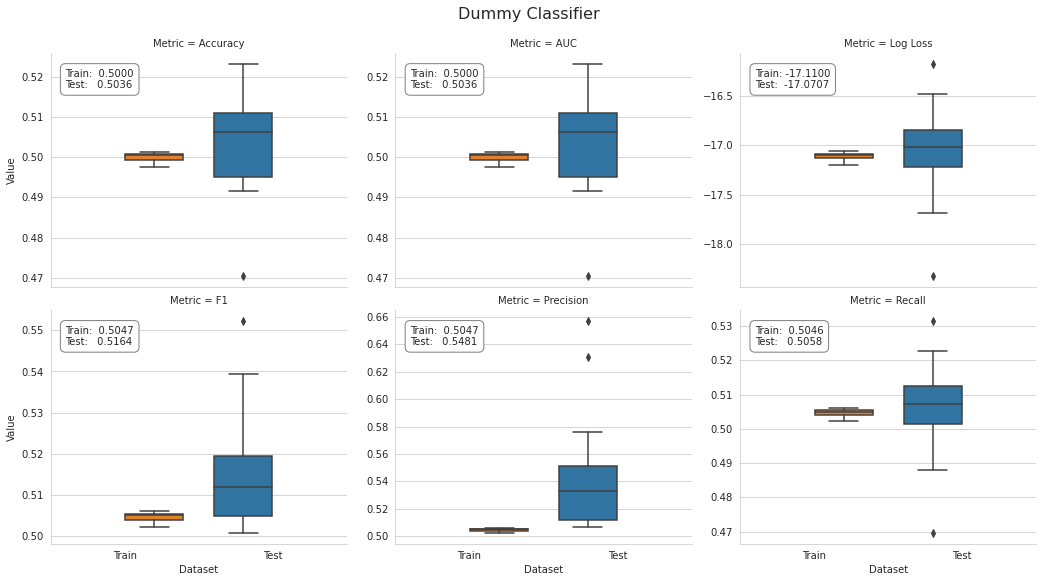

In [25]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 11 on Decision Trees and Random Forests](../11_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [26]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [27]:
algo = 'random_forest'

In [28]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  8.9min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.9min finished


### Plot Results

In [29]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.527617,1.000000
Accuracy,0.517378,0.999999
F1,0.509683,0.999999
Log Loss,-0.692599,-0.169339
Precision,0.567070,0.999999
Recall,0.544931,0.999999


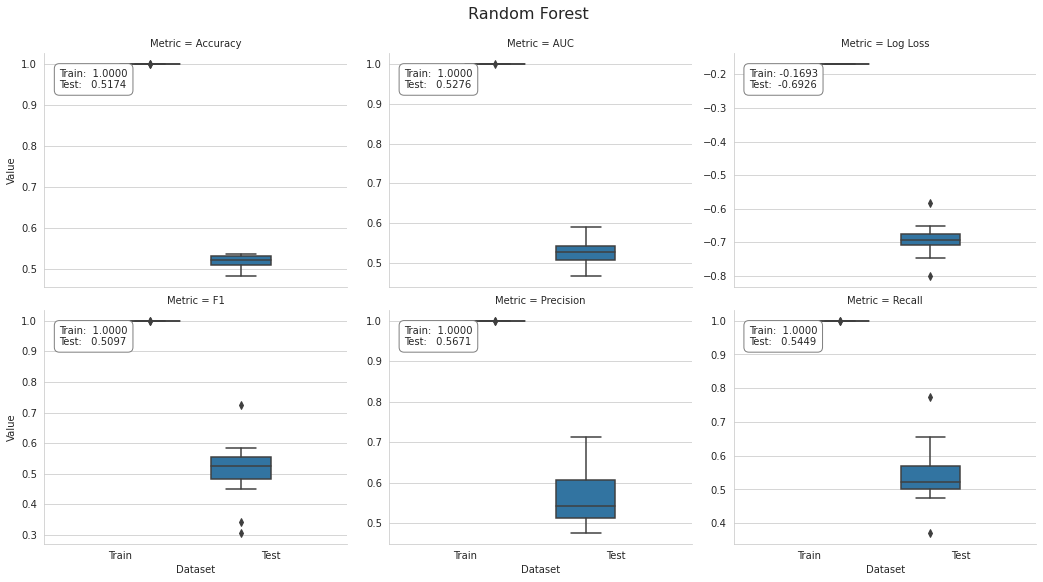

In [30]:
plot_result(rf_result, model='Random Forest')

## scikit-learn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [31]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [32]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=100,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [33]:
algo = 'adaboost'

In [34]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  6.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.6min finished


### Plot Result

In [35]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.536026,0.608159
Accuracy,0.504680,0.569104
F1,0.462678,0.570845
Log Loss,-0.692850,-0.692697
Precision,0.542952,0.583507
Recall,0.571182,0.588091


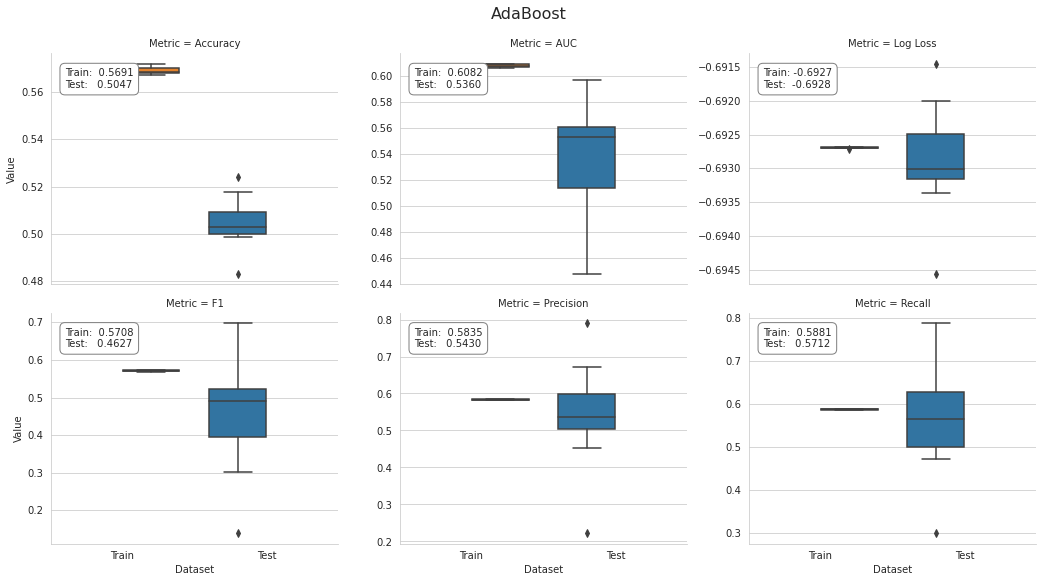

In [36]:
plot_result(ada_result, model='AdaBoost')

## scikit-learn: HistGradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

This estimator is much faster than [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) for big datasets (n_samples >= 10 000).

This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [52]:
gb_clf = HistGradientBoostingClassifier(loss='binary_crossentropy',              
                                        learning_rate=0.1,          # regulates the contribution of each tree
                                        max_iter=100,               # number of boosting stages
                                        min_samples_leaf=20,
                                        max_depth=None,
                                        random_state=None,
                                        max_leaf_nodes=31,           # opt value depends on feature interaction
                                        warm_start=False,
#                                         early_stopping=True,
#                                         scoring='loss',
#                                         validation_fraction=0.1,
#                                         n_iter_no_change=None,
                                        verbose=0,
                                        tol=0.0001)

### Cross-validate

In [53]:
algo = 'sklearn_gbm'

In [54]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   54.4s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   54.5s finished


### Plot Results

In [56]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.536793,0.749371
Accuracy,0.505439,0.675401
F1,0.454815,0.681579
Log Loss,-0.696830,-0.595520
Precision,0.564898,0.693065
Recall,0.555223,0.689508


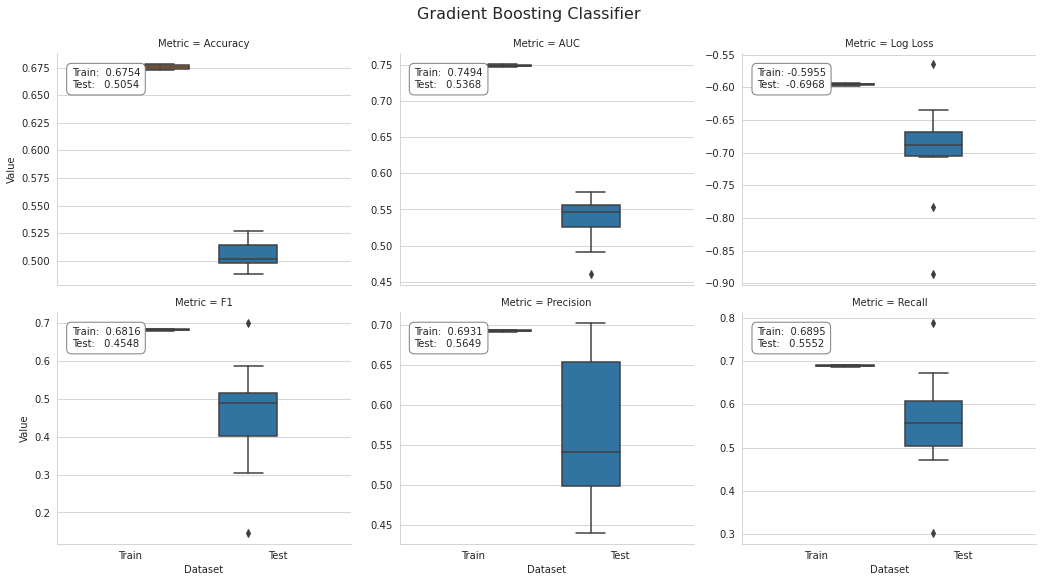

In [57]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plots

Drop time periods to avoid over-reliance for in-sample fit.

In [58]:
X_ = X_factors_clean.drop(['year', 'month'], axis=1)

In [59]:
fname = results_path / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(y=y_clean, X=X_)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

In [60]:
# mean accuracy
gb_clf.score(X=X_, y=y_clean)

0.5864625169378761

In [61]:
y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.611720539220663

#### One-way and two-way partial depende plots

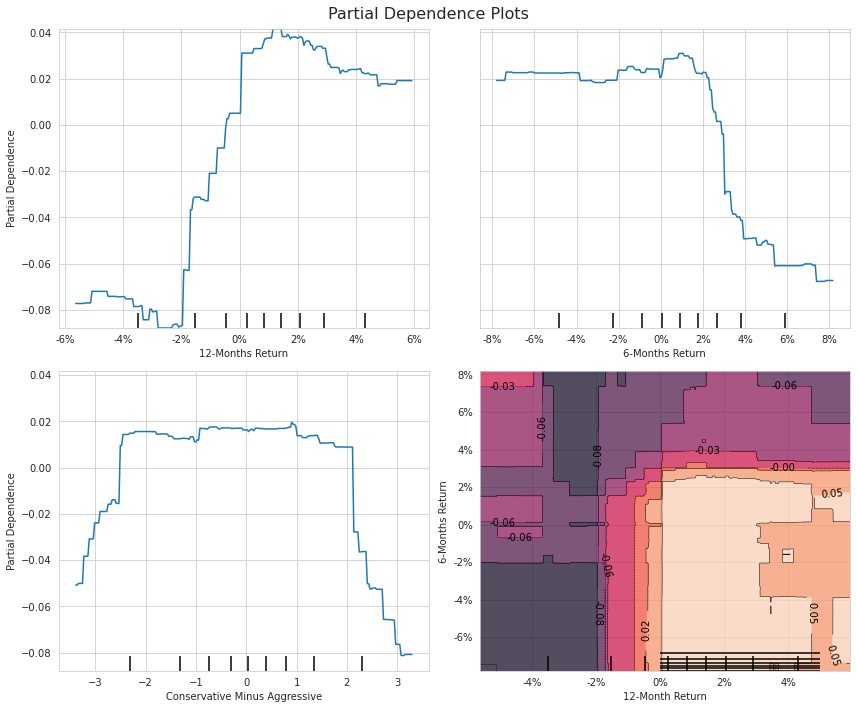

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

plot_partial_dependence(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    n_cols=2,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.savefig('figures/partial_dep_2d', dpi=300);

#### Two-way partial dependence as 3D plot

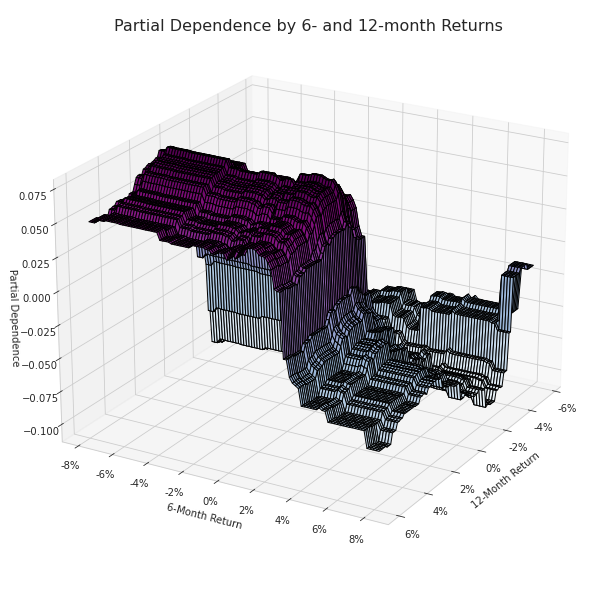

In [65]:
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=targets,
                               X=X_,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout()
fig.savefig('figures/partial_dep_3d', dpi=300)

## XGBoost

See XGBoost [docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) for details on parameters and usage.

### Configure

In [66]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [67]:
algo = 'xgboost'

In [68]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  6.4min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.4min finished


### Plot Results

In [69]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.523467,0.685107
Accuracy,0.501340,0.618366
F1,0.392318,0.621540
Log Loss,-0.705452,-0.643732
Precision,0.503652,0.640619
Recall,0.496645,0.637335


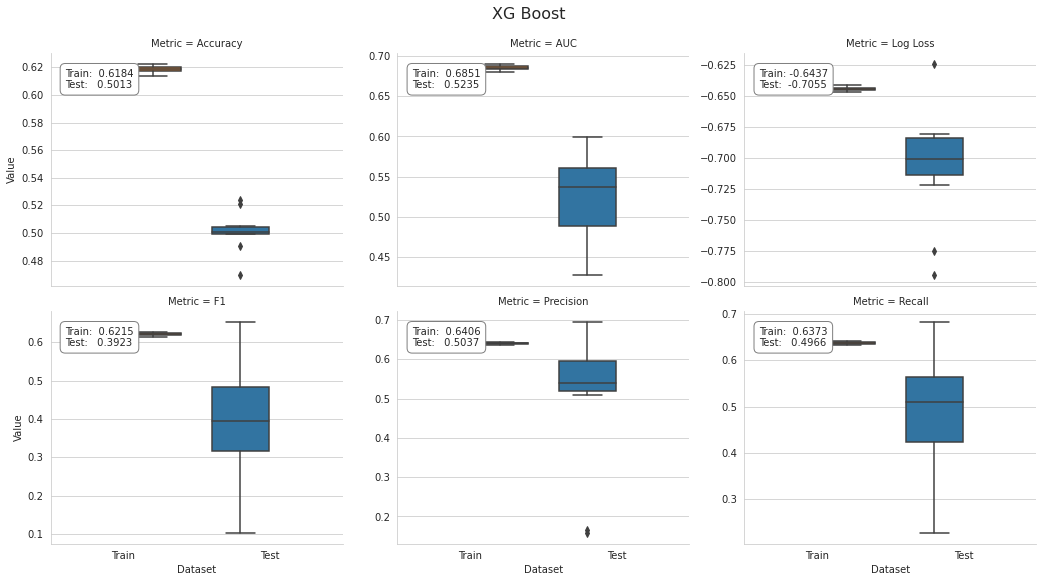

In [70]:
plot_result(xbg_result, model='XG Boost', fname=f'figures/{algo}_cv_result')

### Feature Importance

In [71]:
xgb_clf.fit(X=X_dummies, y=y)

[19:16:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:16:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [72]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X_dummies.columns)

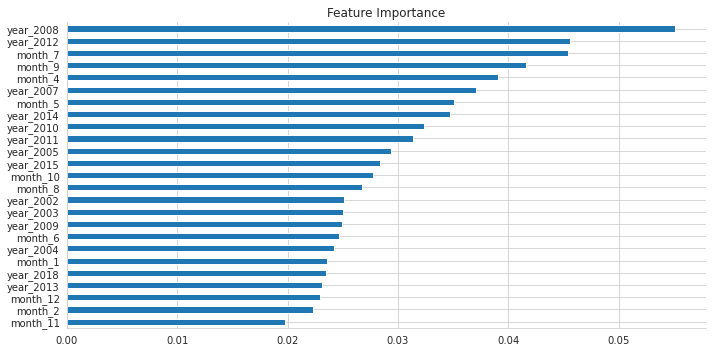

In [73]:
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

## LightGBM

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for details on parameters and usage.

### Configure

In [74]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
                        )

### Cross-Validate

#### Using categorical features

In [75]:
algo = 'lgb_factors'

In [76]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   57.0s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   57.2s finished


##### Plot Results

In [77]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.531961,0.750078
Accuracy,0.507112,0.676947
F1,0.423222,0.683303
Log Loss,-0.723949,-0.592515
Precision,0.555119,0.691271
Recall,0.505033,0.689602


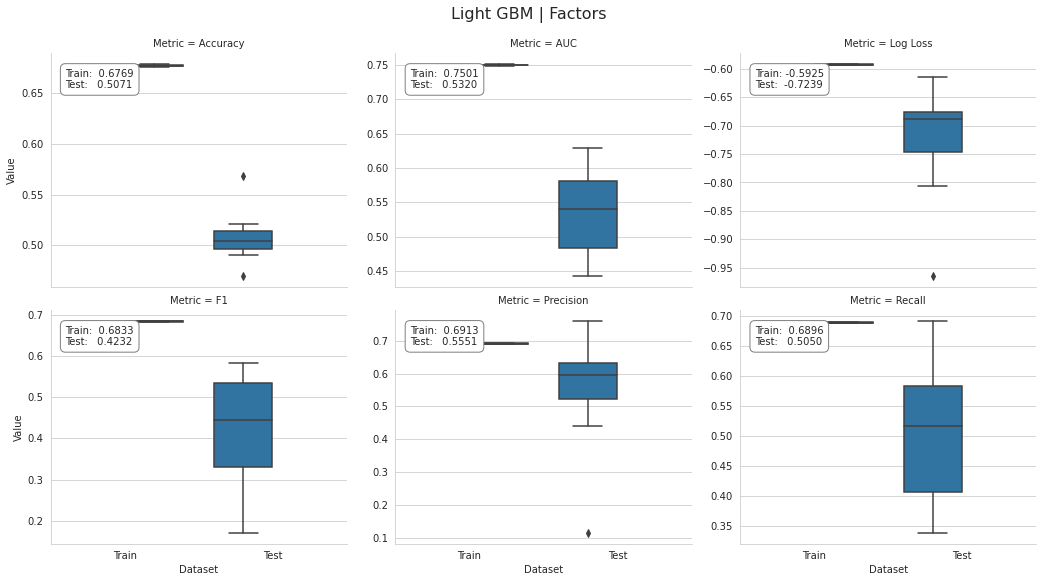

In [78]:
plot_result(lgb_factor_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

#### Using dummy variables

In [79]:
algo = 'lgb_dummies'

In [80]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   49.3s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   49.5s finished


##### Plot results

In [81]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.531726,0.743801
Accuracy,0.512568,0.670181
F1,0.432572,0.676278
Log Loss,-0.704388,-0.600524
Precision,0.563982,0.688815
Recall,0.503945,0.684960


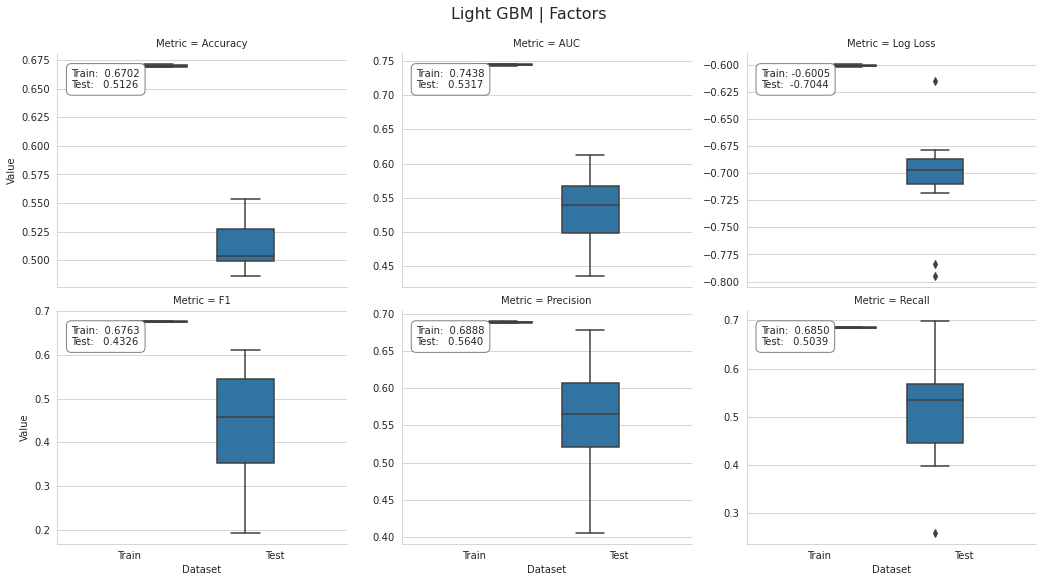

In [82]:
plot_result(lgb_dummy_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

## Catboost

See CatBoost [docs](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) for details on parameters and usage.

### CPU

#### Configure

In [52]:
cat_clf = CatBoostClassifier()

#### Cross-Validate

In [53]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

Catboost requires integer values for categorical variables.

In [54]:
algo = 'catboost'

In [56]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_cv_result, run_time[algo] = run_cv(cat_clf,
                                           X=X_factors,
                                           fit_params=fit_params,
                                           n_jobs=-1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 17.1min remaining:  3.4min


KeyboardInterrupt: 

#### Plot Results

In [87]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.535570,0.802247
Accuracy,0.530186,0.720580
F1,0.539839,0.726449
Log Loss,-0.690083,-0.539102
Precision,0.579023,0.729410
Recall,0.551868,0.729155


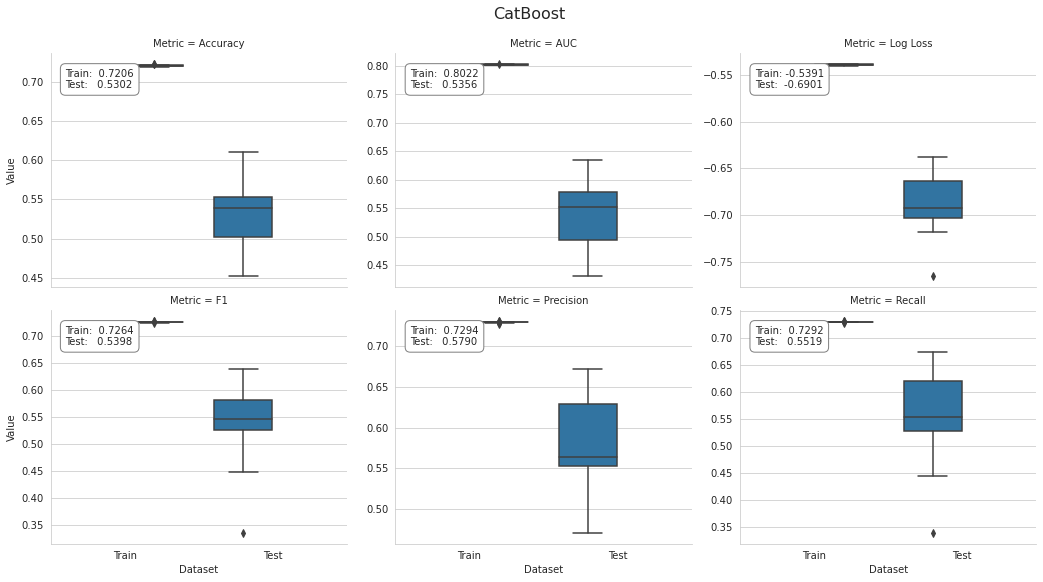

In [88]:
plot_result(cat_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

### GPU

> Naturally, the following requires that you have a GPU and install CatBoost [accordingly](https://catboost.ai/docs/features/training-on-gpu.html). This will NOT work using the provided Docker image even if you have a GPU because CatBoost won't be able to access CUDA. If you want to run CatBoost using GPU, you can just create a Python (virtual) environment and install the libraries needed for this notebook (see `import` statements).

#### Configure

In [21]:
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

#### Cross-Validate

In [22]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [23]:
algo = 'catboost_gpu'

In [24]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu,
                                               y=y,
                                               X=X_factors,
                                               fit_params=fit_params, 
                                               n_jobs=1)
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.024399
0:	learn: 0.6886496	total: 32.3ms	remaining: 32.3s
1:	learn: 0.6844048	total: 56ms	remaining: 28s
2:	learn: 0.6803455	total: 80.2ms	remaining: 26.6s
3:	learn: 0.6764823	total: 106ms	remaining: 26.4s
4:	learn: 0.6728022	total: 132ms	remaining: 26.3s
5:	learn: 0.6692985	total: 155ms	remaining: 25.8s
6:	learn: 0.6660266	total: 182ms	remaining: 25.8s
7:	learn: 0.6628542	total: 204ms	remaining: 25.3s
8:	learn: 0.6598707	total: 231ms	remaining: 25.4s
9:	learn: 0.6569938	total: 255ms	remaining: 25.3s
10:	learn: 0.6543086	total: 283ms	remaining: 25.5s
11:	learn: 0.6516865	total: 312ms	remaining: 25.7s
12:	learn: 0.6491965	total: 339ms	remaining: 25.7s
13:	learn: 0.6468083	total: 361ms	remaining: 25.4s
14:	learn: 0.6445762	total: 385ms	remaining: 25.3s
15:	learn: 0.6424384	total: 417ms	remaining: 25.6s
16:	learn: 0.6403283	total: 441ms	remaining: 25.5s
17:	learn: 0.6383904	total: 462ms	remaining: 25.2s
18:	learn: 0.6364534	total: 488ms	remaining: 25.2s
19:	learn: 0

168:	learn: 0.5891489	total: 4.09s	remaining: 20.1s
169:	learn: 0.5891255	total: 4.12s	remaining: 20.1s
170:	learn: 0.5890868	total: 4.15s	remaining: 20.1s
171:	learn: 0.5890623	total: 4.18s	remaining: 20.1s
172:	learn: 0.5890370	total: 4.2s	remaining: 20.1s
173:	learn: 0.5890153	total: 4.23s	remaining: 20.1s
174:	learn: 0.5889986	total: 4.26s	remaining: 20.1s
175:	learn: 0.5889778	total: 4.28s	remaining: 20.1s
176:	learn: 0.5889605	total: 4.31s	remaining: 20.1s
177:	learn: 0.5889377	total: 4.34s	remaining: 20s
178:	learn: 0.5889210	total: 4.36s	remaining: 20s
179:	learn: 0.5889010	total: 4.39s	remaining: 20s
180:	learn: 0.5888767	total: 4.42s	remaining: 20s
181:	learn: 0.5888623	total: 4.44s	remaining: 20s
182:	learn: 0.5888504	total: 4.47s	remaining: 20s
183:	learn: 0.5888344	total: 4.5s	remaining: 19.9s
184:	learn: 0.5888067	total: 4.53s	remaining: 19.9s
185:	learn: 0.5887722	total: 4.55s	remaining: 19.9s
186:	learn: 0.5887456	total: 4.58s	remaining: 19.9s
187:	learn: 0.5887301	tota

329:	learn: 0.5863059	total: 8.16s	remaining: 16.6s
330:	learn: 0.5862970	total: 8.2s	remaining: 16.6s
331:	learn: 0.5862731	total: 8.22s	remaining: 16.5s
332:	learn: 0.5862501	total: 8.25s	remaining: 16.5s
333:	learn: 0.5862376	total: 8.28s	remaining: 16.5s
334:	learn: 0.5862221	total: 8.3s	remaining: 16.5s
335:	learn: 0.5862022	total: 8.32s	remaining: 16.5s
336:	learn: 0.5861895	total: 8.35s	remaining: 16.4s
337:	learn: 0.5861780	total: 8.38s	remaining: 16.4s
338:	learn: 0.5861723	total: 8.4s	remaining: 16.4s
339:	learn: 0.5861615	total: 8.43s	remaining: 16.4s
340:	learn: 0.5861503	total: 8.46s	remaining: 16.3s
341:	learn: 0.5861408	total: 8.48s	remaining: 16.3s
342:	learn: 0.5861265	total: 8.51s	remaining: 16.3s
343:	learn: 0.5861112	total: 8.53s	remaining: 16.3s
344:	learn: 0.5860980	total: 8.56s	remaining: 16.2s
345:	learn: 0.5860886	total: 8.58s	remaining: 16.2s
346:	learn: 0.5860746	total: 8.61s	remaining: 16.2s
347:	learn: 0.5860501	total: 8.64s	remaining: 16.2s
348:	learn: 0.5

488:	learn: 0.5845267	total: 12.2s	remaining: 12.7s
489:	learn: 0.5845186	total: 12.2s	remaining: 12.7s
490:	learn: 0.5845108	total: 12.2s	remaining: 12.7s
491:	learn: 0.5845013	total: 12.3s	remaining: 12.7s
492:	learn: 0.5844982	total: 12.3s	remaining: 12.6s
493:	learn: 0.5844895	total: 12.3s	remaining: 12.6s
494:	learn: 0.5844818	total: 12.3s	remaining: 12.6s
495:	learn: 0.5844739	total: 12.4s	remaining: 12.6s
496:	learn: 0.5844653	total: 12.4s	remaining: 12.5s
497:	learn: 0.5844588	total: 12.4s	remaining: 12.5s
498:	learn: 0.5844545	total: 12.4s	remaining: 12.5s
499:	learn: 0.5844401	total: 12.5s	remaining: 12.5s
500:	learn: 0.5844355	total: 12.5s	remaining: 12.4s
501:	learn: 0.5844204	total: 12.5s	remaining: 12.4s
502:	learn: 0.5844108	total: 12.5s	remaining: 12.4s
503:	learn: 0.5844040	total: 12.6s	remaining: 12.4s
504:	learn: 0.5843992	total: 12.6s	remaining: 12.3s
505:	learn: 0.5843959	total: 12.6s	remaining: 12.3s
506:	learn: 0.5843861	total: 12.6s	remaining: 12.3s
507:	learn: 

653:	learn: 0.5831417	total: 16.3s	remaining: 8.6s
654:	learn: 0.5831368	total: 16.3s	remaining: 8.57s
655:	learn: 0.5831339	total: 16.3s	remaining: 8.55s
656:	learn: 0.5831212	total: 16.3s	remaining: 8.52s
657:	learn: 0.5831126	total: 16.3s	remaining: 8.49s
658:	learn: 0.5831041	total: 16.4s	remaining: 8.47s
659:	learn: 0.5830969	total: 16.4s	remaining: 8.44s
660:	learn: 0.5830948	total: 16.4s	remaining: 8.41s
661:	learn: 0.5830903	total: 16.4s	remaining: 8.39s
662:	learn: 0.5830860	total: 16.5s	remaining: 8.36s
663:	learn: 0.5830706	total: 16.5s	remaining: 8.34s
664:	learn: 0.5830673	total: 16.5s	remaining: 8.31s
665:	learn: 0.5830638	total: 16.5s	remaining: 8.29s
666:	learn: 0.5830529	total: 16.5s	remaining: 8.26s
667:	learn: 0.5830447	total: 16.6s	remaining: 8.24s
668:	learn: 0.5830404	total: 16.6s	remaining: 8.21s
669:	learn: 0.5830312	total: 16.6s	remaining: 8.19s
670:	learn: 0.5830254	total: 16.6s	remaining: 8.16s
671:	learn: 0.5830165	total: 16.7s	remaining: 8.14s
672:	learn: 0

812:	learn: 0.5820648	total: 20.1s	remaining: 4.63s
813:	learn: 0.5820619	total: 20.1s	remaining: 4.6s
814:	learn: 0.5820582	total: 20.2s	remaining: 4.58s
815:	learn: 0.5820501	total: 20.2s	remaining: 4.55s
816:	learn: 0.5820444	total: 20.2s	remaining: 4.53s
817:	learn: 0.5820330	total: 20.2s	remaining: 4.5s
818:	learn: 0.5820244	total: 20.3s	remaining: 4.47s
819:	learn: 0.5820173	total: 20.3s	remaining: 4.45s
820:	learn: 0.5820071	total: 20.3s	remaining: 4.42s
821:	learn: 0.5820012	total: 20.3s	remaining: 4.4s
822:	learn: 0.5819994	total: 20.3s	remaining: 4.37s
823:	learn: 0.5819926	total: 20.4s	remaining: 4.35s
824:	learn: 0.5819902	total: 20.4s	remaining: 4.32s
825:	learn: 0.5819847	total: 20.4s	remaining: 4.3s
826:	learn: 0.5819820	total: 20.4s	remaining: 4.27s
827:	learn: 0.5819798	total: 20.4s	remaining: 4.25s
828:	learn: 0.5819702	total: 20.5s	remaining: 4.22s
829:	learn: 0.5819629	total: 20.5s	remaining: 4.2s
830:	learn: 0.5819569	total: 20.5s	remaining: 4.17s
831:	learn: 0.581

971:	learn: 0.5810859	total: 24s	remaining: 691ms
972:	learn: 0.5810819	total: 24s	remaining: 666ms
973:	learn: 0.5810796	total: 24s	remaining: 641ms
974:	learn: 0.5810748	total: 24s	remaining: 617ms
975:	learn: 0.5810656	total: 24.1s	remaining: 592ms
976:	learn: 0.5810596	total: 24.1s	remaining: 567ms
977:	learn: 0.5810503	total: 24.1s	remaining: 543ms
978:	learn: 0.5810436	total: 24.1s	remaining: 518ms
979:	learn: 0.5810390	total: 24.2s	remaining: 493ms
980:	learn: 0.5810361	total: 24.2s	remaining: 469ms
981:	learn: 0.5810265	total: 24.2s	remaining: 444ms
982:	learn: 0.5810220	total: 24.2s	remaining: 419ms
983:	learn: 0.5810168	total: 24.3s	remaining: 395ms
984:	learn: 0.5810115	total: 24.3s	remaining: 370ms
985:	learn: 0.5809906	total: 24.3s	remaining: 345ms
986:	learn: 0.5809876	total: 24.3s	remaining: 321ms
987:	learn: 0.5809840	total: 24.4s	remaining: 296ms
988:	learn: 0.5809802	total: 24.4s	remaining: 271ms
989:	learn: 0.5809755	total: 24.4s	remaining: 247ms
990:	learn: 0.580970

136:	learn: 0.5904693	total: 3.22s	remaining: 20.3s
137:	learn: 0.5904307	total: 3.26s	remaining: 20.3s
138:	learn: 0.5903945	total: 3.28s	remaining: 20.3s
139:	learn: 0.5903656	total: 3.31s	remaining: 20.3s
140:	learn: 0.5903324	total: 3.33s	remaining: 20.3s
141:	learn: 0.5902969	total: 3.35s	remaining: 20.3s
142:	learn: 0.5902649	total: 3.38s	remaining: 20.3s
143:	learn: 0.5902296	total: 3.4s	remaining: 20.2s
144:	learn: 0.5902035	total: 3.43s	remaining: 20.2s
145:	learn: 0.5901555	total: 3.45s	remaining: 20.2s
146:	learn: 0.5901259	total: 3.48s	remaining: 20.2s
147:	learn: 0.5901051	total: 3.5s	remaining: 20.1s
148:	learn: 0.5900889	total: 3.53s	remaining: 20.2s
149:	learn: 0.5900579	total: 3.55s	remaining: 20.1s
150:	learn: 0.5900256	total: 3.58s	remaining: 20.1s
151:	learn: 0.5899902	total: 3.61s	remaining: 20.1s
152:	learn: 0.5899662	total: 3.63s	remaining: 20.1s
153:	learn: 0.5899203	total: 3.66s	remaining: 20.1s
154:	learn: 0.5898918	total: 3.68s	remaining: 20.1s
155:	learn: 0.

297:	learn: 0.5872684	total: 7.41s	remaining: 17.5s
298:	learn: 0.5872456	total: 7.44s	remaining: 17.4s
299:	learn: 0.5872338	total: 7.46s	remaining: 17.4s
300:	learn: 0.5872224	total: 7.48s	remaining: 17.4s
301:	learn: 0.5872043	total: 7.51s	remaining: 17.4s
302:	learn: 0.5871926	total: 7.54s	remaining: 17.3s
303:	learn: 0.5871819	total: 7.56s	remaining: 17.3s
304:	learn: 0.5871730	total: 7.59s	remaining: 17.3s
305:	learn: 0.5871577	total: 7.62s	remaining: 17.3s
306:	learn: 0.5871436	total: 7.65s	remaining: 17.3s
307:	learn: 0.5871287	total: 7.68s	remaining: 17.2s
308:	learn: 0.5871184	total: 7.7s	remaining: 17.2s
309:	learn: 0.5870938	total: 7.73s	remaining: 17.2s
310:	learn: 0.5870703	total: 7.76s	remaining: 17.2s
311:	learn: 0.5870280	total: 7.79s	remaining: 17.2s
312:	learn: 0.5870164	total: 7.82s	remaining: 17.2s
313:	learn: 0.5870055	total: 7.84s	remaining: 17.1s
314:	learn: 0.5869877	total: 7.86s	remaining: 17.1s
315:	learn: 0.5869779	total: 7.88s	remaining: 17.1s
316:	learn: 0

460:	learn: 0.5854037	total: 11.6s	remaining: 13.6s
461:	learn: 0.5853973	total: 11.6s	remaining: 13.6s
462:	learn: 0.5853857	total: 11.7s	remaining: 13.5s
463:	learn: 0.5853814	total: 11.7s	remaining: 13.5s
464:	learn: 0.5853740	total: 11.7s	remaining: 13.5s
465:	learn: 0.5853640	total: 11.7s	remaining: 13.5s
466:	learn: 0.5853605	total: 11.8s	remaining: 13.4s
467:	learn: 0.5853530	total: 11.8s	remaining: 13.4s
468:	learn: 0.5853401	total: 11.8s	remaining: 13.4s
469:	learn: 0.5853309	total: 11.8s	remaining: 13.4s
470:	learn: 0.5853193	total: 11.9s	remaining: 13.3s
471:	learn: 0.5853116	total: 11.9s	remaining: 13.3s
472:	learn: 0.5853021	total: 11.9s	remaining: 13.3s
473:	learn: 0.5852962	total: 11.9s	remaining: 13.3s
474:	learn: 0.5852892	total: 12s	remaining: 13.2s
475:	learn: 0.5852852	total: 12s	remaining: 13.2s
476:	learn: 0.5852723	total: 12s	remaining: 13.2s
477:	learn: 0.5852593	total: 12.1s	remaining: 13.2s
478:	learn: 0.5852520	total: 12.1s	remaining: 13.1s
479:	learn: 0.5852

625:	learn: 0.5840663	total: 15.7s	remaining: 9.35s
626:	learn: 0.5840620	total: 15.7s	remaining: 9.33s
627:	learn: 0.5840516	total: 15.7s	remaining: 9.3s
628:	learn: 0.5840434	total: 15.7s	remaining: 9.28s
629:	learn: 0.5840361	total: 15.7s	remaining: 9.25s
630:	learn: 0.5840316	total: 15.8s	remaining: 9.22s
631:	learn: 0.5840256	total: 15.8s	remaining: 9.2s
632:	learn: 0.5840193	total: 15.8s	remaining: 9.17s
633:	learn: 0.5840087	total: 15.8s	remaining: 9.15s
634:	learn: 0.5839954	total: 15.9s	remaining: 9.12s
635:	learn: 0.5839912	total: 15.9s	remaining: 9.09s
636:	learn: 0.5839856	total: 15.9s	remaining: 9.07s
637:	learn: 0.5839809	total: 15.9s	remaining: 9.04s
638:	learn: 0.5839742	total: 16s	remaining: 9.02s
639:	learn: 0.5839700	total: 16s	remaining: 8.99s
640:	learn: 0.5839630	total: 16s	remaining: 8.96s
641:	learn: 0.5839595	total: 16s	remaining: 8.94s
642:	learn: 0.5839516	total: 16.1s	remaining: 8.91s
643:	learn: 0.5839344	total: 16.1s	remaining: 8.89s
644:	learn: 0.5839296	

785:	learn: 0.5828709	total: 19.5s	remaining: 5.31s
786:	learn: 0.5828617	total: 19.5s	remaining: 5.29s
787:	learn: 0.5828589	total: 19.6s	remaining: 5.26s
788:	learn: 0.5828452	total: 19.6s	remaining: 5.24s
789:	learn: 0.5828283	total: 19.6s	remaining: 5.21s
790:	learn: 0.5828229	total: 19.6s	remaining: 5.19s
791:	learn: 0.5828179	total: 19.7s	remaining: 5.16s
792:	learn: 0.5828104	total: 19.7s	remaining: 5.14s
793:	learn: 0.5828055	total: 19.7s	remaining: 5.11s
794:	learn: 0.5828033	total: 19.7s	remaining: 5.09s
795:	learn: 0.5828012	total: 19.8s	remaining: 5.06s
796:	learn: 0.5827965	total: 19.8s	remaining: 5.04s
797:	learn: 0.5827908	total: 19.8s	remaining: 5.01s
798:	learn: 0.5827804	total: 19.8s	remaining: 4.99s
799:	learn: 0.5827766	total: 19.9s	remaining: 4.96s
800:	learn: 0.5827745	total: 19.9s	remaining: 4.94s
801:	learn: 0.5827667	total: 19.9s	remaining: 4.91s
802:	learn: 0.5827643	total: 19.9s	remaining: 4.89s
803:	learn: 0.5827609	total: 20s	remaining: 4.86s
804:	learn: 0.

944:	learn: 0.5819203	total: 23.4s	remaining: 1.36s
945:	learn: 0.5819049	total: 23.4s	remaining: 1.33s
946:	learn: 0.5819011	total: 23.4s	remaining: 1.31s
947:	learn: 0.5818936	total: 23.4s	remaining: 1.28s
948:	learn: 0.5818900	total: 23.5s	remaining: 1.26s
949:	learn: 0.5818831	total: 23.5s	remaining: 1.24s
950:	learn: 0.5818760	total: 23.5s	remaining: 1.21s
951:	learn: 0.5818748	total: 23.5s	remaining: 1.19s
952:	learn: 0.5818721	total: 23.6s	remaining: 1.16s
953:	learn: 0.5818688	total: 23.6s	remaining: 1.14s
954:	learn: 0.5818644	total: 23.6s	remaining: 1.11s
955:	learn: 0.5818585	total: 23.6s	remaining: 1.09s
956:	learn: 0.5818540	total: 23.7s	remaining: 1.06s
957:	learn: 0.5818475	total: 23.7s	remaining: 1.04s
958:	learn: 0.5818433	total: 23.7s	remaining: 1.01s
959:	learn: 0.5818380	total: 23.7s	remaining: 989ms
960:	learn: 0.5818273	total: 23.8s	remaining: 964ms
961:	learn: 0.5818197	total: 23.8s	remaining: 940ms
962:	learn: 0.5818122	total: 23.8s	remaining: 915ms
963:	learn: 

104:	learn: 0.5922699	total: 2.54s	remaining: 21.7s
105:	learn: 0.5921734	total: 2.56s	remaining: 21.6s
106:	learn: 0.5920809	total: 2.59s	remaining: 21.6s
107:	learn: 0.5919725	total: 2.61s	remaining: 21.6s
108:	learn: 0.5918869	total: 2.64s	remaining: 21.6s
109:	learn: 0.5918051	total: 2.66s	remaining: 21.5s
110:	learn: 0.5917361	total: 2.69s	remaining: 21.5s
111:	learn: 0.5916522	total: 2.73s	remaining: 21.6s
112:	learn: 0.5915858	total: 2.75s	remaining: 21.6s
113:	learn: 0.5915175	total: 2.77s	remaining: 21.6s
114:	learn: 0.5914487	total: 2.81s	remaining: 21.6s
115:	learn: 0.5913605	total: 2.84s	remaining: 21.6s
116:	learn: 0.5912889	total: 2.87s	remaining: 21.6s
117:	learn: 0.5912260	total: 2.89s	remaining: 21.6s
118:	learn: 0.5911510	total: 2.92s	remaining: 21.6s
119:	learn: 0.5910933	total: 2.94s	remaining: 21.6s
120:	learn: 0.5910441	total: 2.97s	remaining: 21.5s
121:	learn: 0.5909881	total: 2.99s	remaining: 21.5s
122:	learn: 0.5909314	total: 3.01s	remaining: 21.5s
123:	learn: 

268:	learn: 0.5874102	total: 6.63s	remaining: 18s
269:	learn: 0.5873779	total: 6.65s	remaining: 18s
270:	learn: 0.5873622	total: 6.67s	remaining: 18s
271:	learn: 0.5873457	total: 6.72s	remaining: 18s
272:	learn: 0.5873395	total: 6.75s	remaining: 18s
273:	learn: 0.5873202	total: 6.77s	remaining: 17.9s
274:	learn: 0.5873091	total: 6.79s	remaining: 17.9s
275:	learn: 0.5873040	total: 6.81s	remaining: 17.9s
276:	learn: 0.5872904	total: 6.84s	remaining: 17.8s
277:	learn: 0.5872613	total: 6.86s	remaining: 17.8s
278:	learn: 0.5872461	total: 6.88s	remaining: 17.8s
279:	learn: 0.5872193	total: 6.91s	remaining: 17.8s
280:	learn: 0.5872124	total: 6.93s	remaining: 17.7s
281:	learn: 0.5871970	total: 6.96s	remaining: 17.7s
282:	learn: 0.5871901	total: 6.99s	remaining: 17.7s
283:	learn: 0.5871724	total: 7.03s	remaining: 17.7s
284:	learn: 0.5871612	total: 7.05s	remaining: 17.7s
285:	learn: 0.5871517	total: 7.08s	remaining: 17.7s
286:	learn: 0.5871310	total: 7.11s	remaining: 17.7s
287:	learn: 0.5871200	

434:	learn: 0.5852999	total: 10.6s	remaining: 13.8s
435:	learn: 0.5852928	total: 10.6s	remaining: 13.8s
436:	learn: 0.5852889	total: 10.7s	remaining: 13.7s
437:	learn: 0.5852716	total: 10.7s	remaining: 13.7s
438:	learn: 0.5852613	total: 10.7s	remaining: 13.7s
439:	learn: 0.5852551	total: 10.7s	remaining: 13.7s
440:	learn: 0.5852431	total: 10.8s	remaining: 13.6s
441:	learn: 0.5852328	total: 10.8s	remaining: 13.6s
442:	learn: 0.5852156	total: 10.8s	remaining: 13.6s
443:	learn: 0.5852072	total: 10.8s	remaining: 13.6s
444:	learn: 0.5851986	total: 10.9s	remaining: 13.5s
445:	learn: 0.5851911	total: 10.9s	remaining: 13.5s
446:	learn: 0.5851846	total: 10.9s	remaining: 13.5s
447:	learn: 0.5851756	total: 10.9s	remaining: 13.5s
448:	learn: 0.5851690	total: 10.9s	remaining: 13.4s
449:	learn: 0.5851577	total: 11s	remaining: 13.4s
450:	learn: 0.5851369	total: 11s	remaining: 13.4s
451:	learn: 0.5851239	total: 11s	remaining: 13.4s
452:	learn: 0.5851024	total: 11s	remaining: 13.3s
453:	learn: 0.585088

593:	learn: 0.5838425	total: 14.4s	remaining: 9.81s
594:	learn: 0.5838366	total: 14.4s	remaining: 9.79s
595:	learn: 0.5838246	total: 14.4s	remaining: 9.77s
596:	learn: 0.5838120	total: 14.4s	remaining: 9.74s
597:	learn: 0.5837989	total: 14.5s	remaining: 9.72s
598:	learn: 0.5837881	total: 14.5s	remaining: 9.69s
599:	learn: 0.5837831	total: 14.5s	remaining: 9.68s
600:	learn: 0.5837785	total: 14.5s	remaining: 9.65s
601:	learn: 0.5837749	total: 14.6s	remaining: 9.63s
602:	learn: 0.5837690	total: 14.6s	remaining: 9.6s
603:	learn: 0.5837522	total: 14.6s	remaining: 9.58s
604:	learn: 0.5837392	total: 14.7s	remaining: 9.57s
605:	learn: 0.5837346	total: 14.7s	remaining: 9.56s
606:	learn: 0.5837156	total: 14.7s	remaining: 9.53s
607:	learn: 0.5837099	total: 14.7s	remaining: 9.51s
608:	learn: 0.5837008	total: 14.8s	remaining: 9.48s
609:	learn: 0.5836942	total: 14.8s	remaining: 9.45s
610:	learn: 0.5836838	total: 14.8s	remaining: 9.43s
611:	learn: 0.5836756	total: 14.8s	remaining: 9.4s
612:	learn: 0.

753:	learn: 0.5825159	total: 18.1s	remaining: 5.91s
754:	learn: 0.5825100	total: 18.2s	remaining: 5.89s
755:	learn: 0.5825074	total: 18.2s	remaining: 5.87s
756:	learn: 0.5824987	total: 18.2s	remaining: 5.84s
757:	learn: 0.5824825	total: 18.3s	remaining: 5.83s
758:	learn: 0.5824751	total: 18.3s	remaining: 5.8s
759:	learn: 0.5824721	total: 18.3s	remaining: 5.78s
760:	learn: 0.5824713	total: 18.3s	remaining: 5.75s
761:	learn: 0.5824692	total: 18.3s	remaining: 5.73s
762:	learn: 0.5824665	total: 18.4s	remaining: 5.71s
763:	learn: 0.5824567	total: 18.4s	remaining: 5.68s
764:	learn: 0.5824533	total: 18.4s	remaining: 5.66s
765:	learn: 0.5824507	total: 18.4s	remaining: 5.63s
766:	learn: 0.5824461	total: 18.5s	remaining: 5.61s
767:	learn: 0.5824423	total: 18.5s	remaining: 5.58s
768:	learn: 0.5824397	total: 18.5s	remaining: 5.56s
769:	learn: 0.5824332	total: 18.5s	remaining: 5.53s
770:	learn: 0.5824247	total: 18.5s	remaining: 5.51s
771:	learn: 0.5824136	total: 18.6s	remaining: 5.48s
772:	learn: 0

918:	learn: 0.5815419	total: 22.1s	remaining: 1.95s
919:	learn: 0.5815371	total: 22.2s	remaining: 1.93s
920:	learn: 0.5815333	total: 22.2s	remaining: 1.9s
921:	learn: 0.5815300	total: 22.2s	remaining: 1.88s
922:	learn: 0.5815269	total: 22.2s	remaining: 1.85s
923:	learn: 0.5815248	total: 22.3s	remaining: 1.83s
924:	learn: 0.5815173	total: 22.3s	remaining: 1.81s
925:	learn: 0.5815121	total: 22.3s	remaining: 1.78s
926:	learn: 0.5815065	total: 22.3s	remaining: 1.76s
927:	learn: 0.5815013	total: 22.4s	remaining: 1.73s
928:	learn: 0.5814932	total: 22.4s	remaining: 1.71s
929:	learn: 0.5814869	total: 22.4s	remaining: 1.69s
930:	learn: 0.5814804	total: 22.4s	remaining: 1.66s
931:	learn: 0.5814773	total: 22.4s	remaining: 1.64s
932:	learn: 0.5814746	total: 22.5s	remaining: 1.61s
933:	learn: 0.5814728	total: 22.5s	remaining: 1.59s
934:	learn: 0.5814671	total: 22.5s	remaining: 1.56s
935:	learn: 0.5814647	total: 22.5s	remaining: 1.54s
936:	learn: 0.5814573	total: 22.5s	remaining: 1.52s
937:	learn: 0

85:	learn: 0.5944018	total: 1.93s	remaining: 20.6s
86:	learn: 0.5942240	total: 1.96s	remaining: 20.6s
87:	learn: 0.5940543	total: 1.98s	remaining: 20.6s
88:	learn: 0.5939040	total: 2.01s	remaining: 20.6s
89:	learn: 0.5937517	total: 2.04s	remaining: 20.6s
90:	learn: 0.5935613	total: 2.06s	remaining: 20.6s
91:	learn: 0.5933984	total: 2.08s	remaining: 20.6s
92:	learn: 0.5932743	total: 2.1s	remaining: 20.5s
93:	learn: 0.5931132	total: 2.14s	remaining: 20.6s
94:	learn: 0.5929784	total: 2.16s	remaining: 20.6s
95:	learn: 0.5928498	total: 2.19s	remaining: 20.6s
96:	learn: 0.5927334	total: 2.21s	remaining: 20.6s
97:	learn: 0.5926117	total: 2.23s	remaining: 20.6s
98:	learn: 0.5925258	total: 2.26s	remaining: 20.5s
99:	learn: 0.5924066	total: 2.28s	remaining: 20.5s
100:	learn: 0.5923035	total: 2.3s	remaining: 20.5s
101:	learn: 0.5922021	total: 2.33s	remaining: 20.5s
102:	learn: 0.5920841	total: 2.35s	remaining: 20.5s
103:	learn: 0.5919761	total: 2.38s	remaining: 20.5s
104:	learn: 0.5918757	total: 

248:	learn: 0.5872241	total: 5.94s	remaining: 17.9s
249:	learn: 0.5872100	total: 5.96s	remaining: 17.9s
250:	learn: 0.5871897	total: 5.99s	remaining: 17.9s
251:	learn: 0.5871734	total: 6.01s	remaining: 17.8s
252:	learn: 0.5871569	total: 6.03s	remaining: 17.8s
253:	learn: 0.5871440	total: 6.05s	remaining: 17.8s
254:	learn: 0.5871339	total: 6.08s	remaining: 17.8s
255:	learn: 0.5871029	total: 6.1s	remaining: 17.7s
256:	learn: 0.5870903	total: 6.12s	remaining: 17.7s
257:	learn: 0.5870698	total: 6.15s	remaining: 17.7s
258:	learn: 0.5870547	total: 6.17s	remaining: 17.7s
259:	learn: 0.5870415	total: 6.2s	remaining: 17.6s
260:	learn: 0.5870318	total: 6.23s	remaining: 17.6s
261:	learn: 0.5870179	total: 6.25s	remaining: 17.6s
262:	learn: 0.5869931	total: 6.28s	remaining: 17.6s
263:	learn: 0.5869790	total: 6.3s	remaining: 17.6s
264:	learn: 0.5869668	total: 6.33s	remaining: 17.5s
265:	learn: 0.5869368	total: 6.35s	remaining: 17.5s
266:	learn: 0.5869207	total: 6.38s	remaining: 17.5s
267:	learn: 0.5

415:	learn: 0.5850695	total: 9.94s	remaining: 13.9s
416:	learn: 0.5850580	total: 9.96s	remaining: 13.9s
417:	learn: 0.5850483	total: 9.98s	remaining: 13.9s
418:	learn: 0.5850412	total: 10s	remaining: 13.9s
419:	learn: 0.5850287	total: 10s	remaining: 13.9s
420:	learn: 0.5850154	total: 10.1s	remaining: 13.8s
421:	learn: 0.5850039	total: 10.1s	remaining: 13.8s
422:	learn: 0.5849912	total: 10.1s	remaining: 13.8s
423:	learn: 0.5849839	total: 10.1s	remaining: 13.8s
424:	learn: 0.5849737	total: 10.2s	remaining: 13.7s
425:	learn: 0.5849696	total: 10.2s	remaining: 13.7s
426:	learn: 0.5849615	total: 10.2s	remaining: 13.7s
427:	learn: 0.5849573	total: 10.2s	remaining: 13.7s
428:	learn: 0.5849428	total: 10.3s	remaining: 13.6s
429:	learn: 0.5849362	total: 10.3s	remaining: 13.6s
430:	learn: 0.5849323	total: 10.3s	remaining: 13.6s
431:	learn: 0.5849232	total: 10.3s	remaining: 13.6s
432:	learn: 0.5849155	total: 10.3s	remaining: 13.5s
433:	learn: 0.5849034	total: 10.4s	remaining: 13.5s
434:	learn: 0.58

579:	learn: 0.5835719	total: 13.8s	remaining: 9.99s
580:	learn: 0.5835530	total: 13.8s	remaining: 9.97s
581:	learn: 0.5835378	total: 13.9s	remaining: 9.95s
582:	learn: 0.5835114	total: 13.9s	remaining: 9.93s
583:	learn: 0.5835024	total: 13.9s	remaining: 9.9s
584:	learn: 0.5834913	total: 13.9s	remaining: 9.88s
585:	learn: 0.5834847	total: 13.9s	remaining: 9.85s
586:	learn: 0.5834744	total: 14s	remaining: 9.83s
587:	learn: 0.5834610	total: 14s	remaining: 9.81s
588:	learn: 0.5834512	total: 14s	remaining: 9.78s
589:	learn: 0.5834413	total: 14s	remaining: 9.76s
590:	learn: 0.5834313	total: 14.1s	remaining: 9.74s
591:	learn: 0.5834264	total: 14.1s	remaining: 9.71s
592:	learn: 0.5834214	total: 14.1s	remaining: 9.69s
593:	learn: 0.5834048	total: 14.2s	remaining: 9.67s
594:	learn: 0.5833997	total: 14.2s	remaining: 9.65s
595:	learn: 0.5833888	total: 14.2s	remaining: 9.62s
596:	learn: 0.5833824	total: 14.2s	remaining: 9.6s
597:	learn: 0.5833780	total: 14.2s	remaining: 9.57s
598:	learn: 0.5833713	

740:	learn: 0.5822693	total: 17.6s	remaining: 6.14s
741:	learn: 0.5822476	total: 17.6s	remaining: 6.11s
742:	learn: 0.5822345	total: 17.6s	remaining: 6.09s
743:	learn: 0.5822219	total: 17.6s	remaining: 6.07s
744:	learn: 0.5822143	total: 17.7s	remaining: 6.04s
745:	learn: 0.5822080	total: 17.7s	remaining: 6.02s
746:	learn: 0.5821989	total: 17.7s	remaining: 6s
747:	learn: 0.5821939	total: 17.7s	remaining: 5.97s
748:	learn: 0.5821874	total: 17.7s	remaining: 5.95s
749:	learn: 0.5821732	total: 17.8s	remaining: 5.92s
750:	learn: 0.5821677	total: 17.8s	remaining: 5.9s
751:	learn: 0.5821612	total: 17.8s	remaining: 5.88s
752:	learn: 0.5821593	total: 17.8s	remaining: 5.85s
753:	learn: 0.5821516	total: 17.9s	remaining: 5.83s
754:	learn: 0.5821475	total: 17.9s	remaining: 5.8s
755:	learn: 0.5821438	total: 17.9s	remaining: 5.78s
756:	learn: 0.5821392	total: 17.9s	remaining: 5.76s
757:	learn: 0.5821295	total: 18s	remaining: 5.73s
758:	learn: 0.5821229	total: 18s	remaining: 5.71s
759:	learn: 0.5821160

904:	learn: 0.5811139	total: 21.3s	remaining: 2.24s
905:	learn: 0.5811054	total: 21.3s	remaining: 2.21s
906:	learn: 0.5811036	total: 21.4s	remaining: 2.19s
907:	learn: 0.5811009	total: 21.4s	remaining: 2.17s
908:	learn: 0.5810878	total: 21.4s	remaining: 2.14s
909:	learn: 0.5810814	total: 21.4s	remaining: 2.12s
910:	learn: 0.5810727	total: 21.5s	remaining: 2.1s
911:	learn: 0.5810661	total: 21.5s	remaining: 2.07s
912:	learn: 0.5810630	total: 21.5s	remaining: 2.05s
913:	learn: 0.5810547	total: 21.5s	remaining: 2.03s
914:	learn: 0.5810471	total: 21.6s	remaining: 2s
915:	learn: 0.5810454	total: 21.6s	remaining: 1.98s
916:	learn: 0.5810340	total: 21.6s	remaining: 1.96s
917:	learn: 0.5810286	total: 21.6s	remaining: 1.93s
918:	learn: 0.5810157	total: 21.7s	remaining: 1.91s
919:	learn: 0.5810034	total: 21.7s	remaining: 1.89s
920:	learn: 0.5809868	total: 21.7s	remaining: 1.86s
921:	learn: 0.5809767	total: 21.7s	remaining: 1.84s
922:	learn: 0.5809716	total: 21.8s	remaining: 1.81s
923:	learn: 0.58

67:	learn: 0.5983110	total: 1.52s	remaining: 20.8s
68:	learn: 0.5979792	total: 1.54s	remaining: 20.8s
69:	learn: 0.5977484	total: 1.56s	remaining: 20.8s
70:	learn: 0.5975129	total: 1.58s	remaining: 20.7s
71:	learn: 0.5972777	total: 1.6s	remaining: 20.7s
72:	learn: 0.5970773	total: 1.62s	remaining: 20.6s
73:	learn: 0.5967864	total: 1.65s	remaining: 20.6s
74:	learn: 0.5965311	total: 1.67s	remaining: 20.6s
75:	learn: 0.5963425	total: 1.7s	remaining: 20.6s
76:	learn: 0.5961512	total: 1.72s	remaining: 20.6s
77:	learn: 0.5958935	total: 1.74s	remaining: 20.6s
78:	learn: 0.5956465	total: 1.78s	remaining: 20.7s
79:	learn: 0.5954942	total: 1.8s	remaining: 20.7s
80:	learn: 0.5952550	total: 1.82s	remaining: 20.7s
81:	learn: 0.5950612	total: 1.85s	remaining: 20.7s
82:	learn: 0.5948612	total: 1.87s	remaining: 20.7s
83:	learn: 0.5946793	total: 1.89s	remaining: 20.7s
84:	learn: 0.5944889	total: 1.92s	remaining: 20.6s
85:	learn: 0.5942996	total: 1.94s	remaining: 20.6s
86:	learn: 0.5941030	total: 1.96s	

226:	learn: 0.5875236	total: 5.44s	remaining: 18.5s
227:	learn: 0.5874956	total: 5.47s	remaining: 18.5s
228:	learn: 0.5874730	total: 5.5s	remaining: 18.5s
229:	learn: 0.5874603	total: 5.53s	remaining: 18.5s
230:	learn: 0.5874467	total: 5.55s	remaining: 18.5s
231:	learn: 0.5874357	total: 5.58s	remaining: 18.5s
232:	learn: 0.5874133	total: 5.6s	remaining: 18.4s
233:	learn: 0.5873809	total: 5.62s	remaining: 18.4s
234:	learn: 0.5873657	total: 5.65s	remaining: 18.4s
235:	learn: 0.5873531	total: 5.67s	remaining: 18.4s
236:	learn: 0.5873332	total: 5.69s	remaining: 18.3s
237:	learn: 0.5873050	total: 5.72s	remaining: 18.3s
238:	learn: 0.5872785	total: 5.74s	remaining: 18.3s
239:	learn: 0.5872637	total: 5.76s	remaining: 18.3s
240:	learn: 0.5872387	total: 5.79s	remaining: 18.2s
241:	learn: 0.5872244	total: 5.82s	remaining: 18.2s
242:	learn: 0.5872027	total: 5.84s	remaining: 18.2s
243:	learn: 0.5871905	total: 5.86s	remaining: 18.2s
244:	learn: 0.5871629	total: 5.89s	remaining: 18.2s
245:	learn: 0.

385:	learn: 0.5851944	total: 9.25s	remaining: 14.7s
386:	learn: 0.5851822	total: 9.27s	remaining: 14.7s
387:	learn: 0.5851683	total: 9.29s	remaining: 14.7s
388:	learn: 0.5851616	total: 9.31s	remaining: 14.6s
389:	learn: 0.5851560	total: 9.33s	remaining: 14.6s
390:	learn: 0.5851407	total: 9.36s	remaining: 14.6s
391:	learn: 0.5851328	total: 9.38s	remaining: 14.6s
392:	learn: 0.5851204	total: 9.4s	remaining: 14.5s
393:	learn: 0.5851089	total: 9.42s	remaining: 14.5s
394:	learn: 0.5850924	total: 9.45s	remaining: 14.5s
395:	learn: 0.5850891	total: 9.47s	remaining: 14.4s
396:	learn: 0.5850775	total: 9.49s	remaining: 14.4s
397:	learn: 0.5850719	total: 9.52s	remaining: 14.4s
398:	learn: 0.5850603	total: 9.54s	remaining: 14.4s
399:	learn: 0.5850522	total: 9.56s	remaining: 14.3s
400:	learn: 0.5850441	total: 9.58s	remaining: 14.3s
401:	learn: 0.5850219	total: 9.6s	remaining: 14.3s
402:	learn: 0.5850157	total: 9.62s	remaining: 14.3s
403:	learn: 0.5850110	total: 9.65s	remaining: 14.2s
404:	learn: 0.

545:	learn: 0.5836011	total: 13s	remaining: 10.8s
546:	learn: 0.5835969	total: 13s	remaining: 10.8s
547:	learn: 0.5835894	total: 13.1s	remaining: 10.8s
548:	learn: 0.5835823	total: 13.1s	remaining: 10.8s
549:	learn: 0.5835765	total: 13.1s	remaining: 10.7s
550:	learn: 0.5835702	total: 13.1s	remaining: 10.7s
551:	learn: 0.5835652	total: 13.2s	remaining: 10.7s
552:	learn: 0.5835591	total: 13.2s	remaining: 10.6s
553:	learn: 0.5835542	total: 13.2s	remaining: 10.6s
554:	learn: 0.5835466	total: 13.2s	remaining: 10.6s
555:	learn: 0.5835361	total: 13.2s	remaining: 10.6s
556:	learn: 0.5835209	total: 13.3s	remaining: 10.6s
557:	learn: 0.5835097	total: 13.3s	remaining: 10.5s
558:	learn: 0.5835031	total: 13.3s	remaining: 10.5s
559:	learn: 0.5834804	total: 13.3s	remaining: 10.5s
560:	learn: 0.5834742	total: 13.4s	remaining: 10.5s
561:	learn: 0.5834580	total: 13.4s	remaining: 10.4s
562:	learn: 0.5834481	total: 13.4s	remaining: 10.4s
563:	learn: 0.5834349	total: 13.4s	remaining: 10.4s
564:	learn: 0.58

709:	learn: 0.5821904	total: 16.9s	remaining: 6.88s
710:	learn: 0.5821830	total: 16.9s	remaining: 6.86s
711:	learn: 0.5821770	total: 16.9s	remaining: 6.83s
712:	learn: 0.5821724	total: 16.9s	remaining: 6.81s
713:	learn: 0.5821698	total: 16.9s	remaining: 6.79s
714:	learn: 0.5821638	total: 17s	remaining: 6.76s
715:	learn: 0.5821513	total: 17s	remaining: 6.74s
716:	learn: 0.5821404	total: 17s	remaining: 6.71s
717:	learn: 0.5821310	total: 17s	remaining: 6.69s
718:	learn: 0.5821140	total: 17.1s	remaining: 6.67s
719:	learn: 0.5821038	total: 17.1s	remaining: 6.64s
720:	learn: 0.5820820	total: 17.1s	remaining: 6.62s
721:	learn: 0.5820793	total: 17.1s	remaining: 6.6s
722:	learn: 0.5820649	total: 17.2s	remaining: 6.57s
723:	learn: 0.5820570	total: 17.2s	remaining: 6.55s
724:	learn: 0.5820485	total: 17.2s	remaining: 6.52s
725:	learn: 0.5820355	total: 17.2s	remaining: 6.5s
726:	learn: 0.5820308	total: 17.2s	remaining: 6.47s
727:	learn: 0.5820250	total: 17.3s	remaining: 6.45s
728:	learn: 0.5820199	

873:	learn: 0.5811263	total: 20.7s	remaining: 2.98s
874:	learn: 0.5811237	total: 20.7s	remaining: 2.96s
875:	learn: 0.5811200	total: 20.7s	remaining: 2.93s
876:	learn: 0.5811170	total: 20.8s	remaining: 2.91s
877:	learn: 0.5811116	total: 20.8s	remaining: 2.89s
878:	learn: 0.5811075	total: 20.8s	remaining: 2.86s
879:	learn: 0.5811050	total: 20.8s	remaining: 2.84s
880:	learn: 0.5811025	total: 20.8s	remaining: 2.81s
881:	learn: 0.5811000	total: 20.9s	remaining: 2.79s
882:	learn: 0.5810970	total: 20.9s	remaining: 2.77s
883:	learn: 0.5810957	total: 20.9s	remaining: 2.74s
884:	learn: 0.5810865	total: 20.9s	remaining: 2.72s
885:	learn: 0.5810826	total: 20.9s	remaining: 2.69s
886:	learn: 0.5810807	total: 21s	remaining: 2.67s
887:	learn: 0.5810780	total: 21s	remaining: 2.65s
888:	learn: 0.5810710	total: 21s	remaining: 2.62s
889:	learn: 0.5810657	total: 21s	remaining: 2.6s
890:	learn: 0.5810594	total: 21.1s	remaining: 2.58s
891:	learn: 0.5810486	total: 21.1s	remaining: 2.55s
892:	learn: 0.5810469

40:	learn: 0.6097592	total: 883ms	remaining: 20.7s
41:	learn: 0.6090891	total: 906ms	remaining: 20.7s
42:	learn: 0.6083953	total: 928ms	remaining: 20.7s
43:	learn: 0.6077315	total: 950ms	remaining: 20.6s
44:	learn: 0.6070926	total: 972ms	remaining: 20.6s
45:	learn: 0.6064967	total: 992ms	remaining: 20.6s
46:	learn: 0.6059515	total: 1.01s	remaining: 20.6s
47:	learn: 0.6053884	total: 1.05s	remaining: 20.8s
48:	learn: 0.6048858	total: 1.07s	remaining: 20.8s
49:	learn: 0.6043729	total: 1.09s	remaining: 20.8s
50:	learn: 0.6038792	total: 1.12s	remaining: 20.8s
51:	learn: 0.6034022	total: 1.15s	remaining: 21s
52:	learn: 0.6029718	total: 1.19s	remaining: 21.2s
53:	learn: 0.6025104	total: 1.22s	remaining: 21.3s
54:	learn: 0.6020630	total: 1.24s	remaining: 21.3s
55:	learn: 0.6016507	total: 1.26s	remaining: 21.2s
56:	learn: 0.6012872	total: 1.28s	remaining: 21.2s
57:	learn: 0.6009455	total: 1.3s	remaining: 21.1s
58:	learn: 0.6005602	total: 1.32s	remaining: 21.1s
59:	learn: 0.6002117	total: 1.34s	

204:	learn: 0.5874946	total: 4.85s	remaining: 18.8s
205:	learn: 0.5874851	total: 4.87s	remaining: 18.8s
206:	learn: 0.5874745	total: 4.9s	remaining: 18.8s
207:	learn: 0.5874414	total: 4.92s	remaining: 18.8s
208:	learn: 0.5874186	total: 4.95s	remaining: 18.7s
209:	learn: 0.5874051	total: 4.98s	remaining: 18.7s
210:	learn: 0.5873831	total: 5.01s	remaining: 18.7s
211:	learn: 0.5873561	total: 5.03s	remaining: 18.7s
212:	learn: 0.5873343	total: 5.05s	remaining: 18.7s
213:	learn: 0.5873033	total: 5.08s	remaining: 18.6s
214:	learn: 0.5872895	total: 5.1s	remaining: 18.6s
215:	learn: 0.5872784	total: 5.12s	remaining: 18.6s
216:	learn: 0.5872601	total: 5.14s	remaining: 18.6s
217:	learn: 0.5872444	total: 5.17s	remaining: 18.6s
218:	learn: 0.5872299	total: 5.2s	remaining: 18.5s
219:	learn: 0.5872160	total: 5.22s	remaining: 18.5s
220:	learn: 0.5871875	total: 5.25s	remaining: 18.5s
221:	learn: 0.5871719	total: 5.27s	remaining: 18.5s
222:	learn: 0.5871609	total: 5.29s	remaining: 18.4s
223:	learn: 0.5

369:	learn: 0.5850024	total: 8.88s	remaining: 15.1s
370:	learn: 0.5849870	total: 8.9s	remaining: 15.1s
371:	learn: 0.5849818	total: 8.93s	remaining: 15.1s
372:	learn: 0.5849731	total: 8.95s	remaining: 15s
373:	learn: 0.5849646	total: 8.98s	remaining: 15s
374:	learn: 0.5849568	total: 9.01s	remaining: 15s
375:	learn: 0.5849442	total: 9.03s	remaining: 15s
376:	learn: 0.5849347	total: 9.06s	remaining: 15s
377:	learn: 0.5849241	total: 9.08s	remaining: 14.9s
378:	learn: 0.5849110	total: 9.1s	remaining: 14.9s
379:	learn: 0.5848963	total: 9.12s	remaining: 14.9s
380:	learn: 0.5848878	total: 9.15s	remaining: 14.9s
381:	learn: 0.5848732	total: 9.19s	remaining: 14.9s
382:	learn: 0.5848646	total: 9.21s	remaining: 14.8s
383:	learn: 0.5848524	total: 9.23s	remaining: 14.8s
384:	learn: 0.5848386	total: 9.26s	remaining: 14.8s
385:	learn: 0.5848267	total: 9.28s	remaining: 14.8s
386:	learn: 0.5848201	total: 9.3s	remaining: 14.7s
387:	learn: 0.5848162	total: 9.33s	remaining: 14.7s
388:	learn: 0.5848107	tot

530:	learn: 0.5834401	total: 12.7s	remaining: 11.2s
531:	learn: 0.5834356	total: 12.7s	remaining: 11.2s
532:	learn: 0.5834241	total: 12.7s	remaining: 11.1s
533:	learn: 0.5834201	total: 12.7s	remaining: 11.1s
534:	learn: 0.5834078	total: 12.8s	remaining: 11.1s
535:	learn: 0.5834003	total: 12.8s	remaining: 11.1s
536:	learn: 0.5833936	total: 12.8s	remaining: 11s
537:	learn: 0.5833773	total: 12.8s	remaining: 11s
538:	learn: 0.5833658	total: 12.9s	remaining: 11s
539:	learn: 0.5833603	total: 12.9s	remaining: 11s
540:	learn: 0.5833557	total: 12.9s	remaining: 10.9s
541:	learn: 0.5833527	total: 12.9s	remaining: 10.9s
542:	learn: 0.5833417	total: 13s	remaining: 10.9s
543:	learn: 0.5833348	total: 13s	remaining: 10.9s
544:	learn: 0.5833219	total: 13s	remaining: 10.9s
545:	learn: 0.5833127	total: 13s	remaining: 10.8s
546:	learn: 0.5833085	total: 13.1s	remaining: 10.8s
547:	learn: 0.5832998	total: 13.1s	remaining: 10.8s
548:	learn: 0.5832921	total: 13.1s	remaining: 10.8s
549:	learn: 0.5832804	total:

693:	learn: 0.5821061	total: 16.5s	remaining: 7.27s
694:	learn: 0.5821020	total: 16.5s	remaining: 7.25s
695:	learn: 0.5820974	total: 16.6s	remaining: 7.23s
696:	learn: 0.5820915	total: 16.6s	remaining: 7.21s
697:	learn: 0.5820853	total: 16.6s	remaining: 7.18s
698:	learn: 0.5820602	total: 16.6s	remaining: 7.16s
699:	learn: 0.5820528	total: 16.6s	remaining: 7.13s
700:	learn: 0.5820474	total: 16.7s	remaining: 7.11s
701:	learn: 0.5820335	total: 16.7s	remaining: 7.09s
702:	learn: 0.5820278	total: 16.7s	remaining: 7.06s
703:	learn: 0.5820134	total: 16.7s	remaining: 7.04s
704:	learn: 0.5820090	total: 16.8s	remaining: 7.02s
705:	learn: 0.5820044	total: 16.8s	remaining: 6.99s
706:	learn: 0.5819971	total: 16.8s	remaining: 6.97s
707:	learn: 0.5819924	total: 16.8s	remaining: 6.94s
708:	learn: 0.5819875	total: 16.9s	remaining: 6.92s
709:	learn: 0.5819808	total: 16.9s	remaining: 6.89s
710:	learn: 0.5819719	total: 16.9s	remaining: 6.87s
711:	learn: 0.5819686	total: 16.9s	remaining: 6.84s
712:	learn: 

853:	learn: 0.5810594	total: 20.2s	remaining: 3.46s
854:	learn: 0.5810544	total: 20.3s	remaining: 3.43s
855:	learn: 0.5810516	total: 20.3s	remaining: 3.41s
856:	learn: 0.5810441	total: 20.3s	remaining: 3.39s
857:	learn: 0.5810411	total: 20.3s	remaining: 3.36s
858:	learn: 0.5810293	total: 20.3s	remaining: 3.34s
859:	learn: 0.5810211	total: 20.4s	remaining: 3.31s
860:	learn: 0.5810152	total: 20.4s	remaining: 3.29s
861:	learn: 0.5810126	total: 20.4s	remaining: 3.27s
862:	learn: 0.5810071	total: 20.4s	remaining: 3.24s
863:	learn: 0.5810024	total: 20.5s	remaining: 3.22s
864:	learn: 0.5809945	total: 20.5s	remaining: 3.2s
865:	learn: 0.5809885	total: 20.5s	remaining: 3.17s
866:	learn: 0.5809869	total: 20.5s	remaining: 3.15s
867:	learn: 0.5809810	total: 20.5s	remaining: 3.13s
868:	learn: 0.5809695	total: 20.6s	remaining: 3.1s
869:	learn: 0.5809558	total: 20.6s	remaining: 3.08s
870:	learn: 0.5809472	total: 20.6s	remaining: 3.05s
871:	learn: 0.5809370	total: 20.6s	remaining: 3.03s
872:	learn: 0.

18:	learn: 0.6360942	total: 442ms	remaining: 22.8s
19:	learn: 0.6343108	total: 464ms	remaining: 22.7s
20:	learn: 0.6325741	total: 487ms	remaining: 22.7s
21:	learn: 0.6309382	total: 509ms	remaining: 22.6s
22:	learn: 0.6293441	total: 531ms	remaining: 22.5s
23:	learn: 0.6278961	total: 554ms	remaining: 22.5s
24:	learn: 0.6264110	total: 576ms	remaining: 22.5s
25:	learn: 0.6250456	total: 598ms	remaining: 22.4s
26:	learn: 0.6236982	total: 619ms	remaining: 22.3s
27:	learn: 0.6225069	total: 640ms	remaining: 22.2s
28:	learn: 0.6212584	total: 662ms	remaining: 22.2s
29:	learn: 0.6200894	total: 684ms	remaining: 22.1s
30:	learn: 0.6189302	total: 705ms	remaining: 22s
31:	learn: 0.6178666	total: 726ms	remaining: 22s
32:	learn: 0.6168574	total: 748ms	remaining: 21.9s
33:	learn: 0.6158591	total: 769ms	remaining: 21.9s
34:	learn: 0.6149335	total: 791ms	remaining: 21.8s
35:	learn: 0.6140777	total: 813ms	remaining: 21.8s
36:	learn: 0.6131884	total: 833ms	remaining: 21.7s
37:	learn: 0.6123810	total: 855ms	r

184:	learn: 0.5883312	total: 4.28s	remaining: 18.8s
185:	learn: 0.5883131	total: 4.3s	remaining: 18.8s
186:	learn: 0.5882888	total: 4.32s	remaining: 18.8s
187:	learn: 0.5882644	total: 4.35s	remaining: 18.8s
188:	learn: 0.5882461	total: 4.37s	remaining: 18.8s
189:	learn: 0.5882277	total: 4.4s	remaining: 18.7s
190:	learn: 0.5882079	total: 4.42s	remaining: 18.7s
191:	learn: 0.5881938	total: 4.45s	remaining: 18.7s
192:	learn: 0.5881737	total: 4.47s	remaining: 18.7s
193:	learn: 0.5881616	total: 4.49s	remaining: 18.7s
194:	learn: 0.5881358	total: 4.52s	remaining: 18.6s
195:	learn: 0.5881097	total: 4.54s	remaining: 18.6s
196:	learn: 0.5880863	total: 4.56s	remaining: 18.6s
197:	learn: 0.5880695	total: 4.59s	remaining: 18.6s
198:	learn: 0.5880340	total: 4.61s	remaining: 18.6s
199:	learn: 0.5880139	total: 4.63s	remaining: 18.5s
200:	learn: 0.5879979	total: 4.66s	remaining: 18.5s
201:	learn: 0.5879727	total: 4.68s	remaining: 18.5s
202:	learn: 0.5879511	total: 4.71s	remaining: 18.5s
203:	learn: 0.

345:	learn: 0.5857159	total: 8.05s	remaining: 15.2s
346:	learn: 0.5856944	total: 8.07s	remaining: 15.2s
347:	learn: 0.5856786	total: 8.1s	remaining: 15.2s
348:	learn: 0.5856731	total: 8.12s	remaining: 15.1s
349:	learn: 0.5856663	total: 8.14s	remaining: 15.1s
350:	learn: 0.5856521	total: 8.17s	remaining: 15.1s
351:	learn: 0.5856311	total: 8.19s	remaining: 15.1s
352:	learn: 0.5856205	total: 8.21s	remaining: 15s
353:	learn: 0.5856115	total: 8.23s	remaining: 15s
354:	learn: 0.5856040	total: 8.26s	remaining: 15s
355:	learn: 0.5855973	total: 8.28s	remaining: 15s
356:	learn: 0.5855875	total: 8.3s	remaining: 15s
357:	learn: 0.5855771	total: 8.32s	remaining: 14.9s
358:	learn: 0.5855655	total: 8.35s	remaining: 14.9s
359:	learn: 0.5855557	total: 8.37s	remaining: 14.9s
360:	learn: 0.5855436	total: 8.39s	remaining: 14.9s
361:	learn: 0.5855342	total: 8.42s	remaining: 14.8s
362:	learn: 0.5855141	total: 8.44s	remaining: 14.8s
363:	learn: 0.5855038	total: 8.46s	remaining: 14.8s
364:	learn: 0.5854932	to

505:	learn: 0.5840278	total: 11.7s	remaining: 11.4s
506:	learn: 0.5840194	total: 11.7s	remaining: 11.4s
507:	learn: 0.5840126	total: 11.7s	remaining: 11.3s
508:	learn: 0.5840068	total: 11.7s	remaining: 11.3s
509:	learn: 0.5840023	total: 11.8s	remaining: 11.3s
510:	learn: 0.5839962	total: 11.8s	remaining: 11.3s
511:	learn: 0.5839924	total: 11.8s	remaining: 11.3s
512:	learn: 0.5839865	total: 11.8s	remaining: 11.2s
513:	learn: 0.5839741	total: 11.8s	remaining: 11.2s
514:	learn: 0.5839681	total: 11.9s	remaining: 11.2s
515:	learn: 0.5839661	total: 11.9s	remaining: 11.2s
516:	learn: 0.5839612	total: 11.9s	remaining: 11.1s
517:	learn: 0.5839525	total: 11.9s	remaining: 11.1s
518:	learn: 0.5839467	total: 12s	remaining: 11.1s
519:	learn: 0.5839388	total: 12s	remaining: 11.1s
520:	learn: 0.5839227	total: 12s	remaining: 11s
521:	learn: 0.5839194	total: 12s	remaining: 11s
522:	learn: 0.5839099	total: 12.1s	remaining: 11s
523:	learn: 0.5839055	total: 12.1s	remaining: 11s
524:	learn: 0.5838993	total:

668:	learn: 0.5827791	total: 15.3s	remaining: 7.56s
669:	learn: 0.5827755	total: 15.3s	remaining: 7.54s
670:	learn: 0.5827683	total: 15.3s	remaining: 7.52s
671:	learn: 0.5827593	total: 15.4s	remaining: 7.49s
672:	learn: 0.5827500	total: 15.4s	remaining: 7.47s
673:	learn: 0.5827285	total: 15.4s	remaining: 7.45s
674:	learn: 0.5827213	total: 15.4s	remaining: 7.42s
675:	learn: 0.5827141	total: 15.4s	remaining: 7.4s
676:	learn: 0.5827051	total: 15.5s	remaining: 7.38s
677:	learn: 0.5827020	total: 15.5s	remaining: 7.35s
678:	learn: 0.5826976	total: 15.5s	remaining: 7.33s
679:	learn: 0.5826904	total: 15.5s	remaining: 7.31s
680:	learn: 0.5826825	total: 15.6s	remaining: 7.29s
681:	learn: 0.5826757	total: 15.6s	remaining: 7.26s
682:	learn: 0.5826646	total: 15.6s	remaining: 7.24s
683:	learn: 0.5826596	total: 15.6s	remaining: 7.22s
684:	learn: 0.5826544	total: 15.7s	remaining: 7.2s
685:	learn: 0.5826404	total: 15.7s	remaining: 7.17s
686:	learn: 0.5826231	total: 15.7s	remaining: 7.15s
687:	learn: 0.

836:	learn: 0.5816349	total: 19.1s	remaining: 3.72s
837:	learn: 0.5816299	total: 19.1s	remaining: 3.7s
838:	learn: 0.5816255	total: 19.2s	remaining: 3.68s
839:	learn: 0.5816216	total: 19.2s	remaining: 3.65s
840:	learn: 0.5816167	total: 19.2s	remaining: 3.63s
841:	learn: 0.5816015	total: 19.2s	remaining: 3.61s
842:	learn: 0.5815961	total: 19.3s	remaining: 3.59s
843:	learn: 0.5815920	total: 19.3s	remaining: 3.56s
844:	learn: 0.5815902	total: 19.3s	remaining: 3.54s
845:	learn: 0.5815811	total: 19.3s	remaining: 3.52s
846:	learn: 0.5815703	total: 19.4s	remaining: 3.5s
847:	learn: 0.5815618	total: 19.4s	remaining: 3.47s
848:	learn: 0.5815575	total: 19.4s	remaining: 3.45s
849:	learn: 0.5815511	total: 19.4s	remaining: 3.43s
850:	learn: 0.5815474	total: 19.4s	remaining: 3.4s
851:	learn: 0.5815339	total: 19.5s	remaining: 3.38s
852:	learn: 0.5815231	total: 19.5s	remaining: 3.36s
853:	learn: 0.5815165	total: 19.5s	remaining: 3.33s
854:	learn: 0.5815087	total: 19.5s	remaining: 3.31s
855:	learn: 0.5

998:	learn: 0.5805955	total: 22.9s	remaining: 22.9ms
999:	learn: 0.5805935	total: 22.9s	remaining: 0us
Learning rate set to 0.024448
0:	learn: 0.6886197	total: 22.2ms	remaining: 22.2s
1:	learn: 0.6843781	total: 43.7ms	remaining: 21.8s
2:	learn: 0.6803139	total: 66.1ms	remaining: 22s
3:	learn: 0.6764034	total: 87.6ms	remaining: 21.8s
4:	learn: 0.6726920	total: 119ms	remaining: 23.6s
5:	learn: 0.6691786	total: 141ms	remaining: 23.4s
6:	learn: 0.6657995	total: 163ms	remaining: 23.1s
7:	learn: 0.6626186	total: 188ms	remaining: 23.4s
8:	learn: 0.6595529	total: 210ms	remaining: 23.1s
9:	learn: 0.6566122	total: 232ms	remaining: 23s
10:	learn: 0.6539540	total: 254ms	remaining: 22.8s
11:	learn: 0.6513461	total: 275ms	remaining: 22.7s
12:	learn: 0.6488566	total: 297ms	remaining: 22.5s
13:	learn: 0.6464954	total: 319ms	remaining: 22.5s
14:	learn: 0.6441588	total: 340ms	remaining: 22.3s
15:	learn: 0.6419904	total: 367ms	remaining: 22.6s
16:	learn: 0.6399267	total: 405ms	remaining: 23.4s
17:	learn:

161:	learn: 0.5884159	total: 3.89s	remaining: 20.1s
162:	learn: 0.5883849	total: 3.91s	remaining: 20.1s
163:	learn: 0.5883625	total: 3.93s	remaining: 20.1s
164:	learn: 0.5883421	total: 3.96s	remaining: 20s
165:	learn: 0.5883202	total: 3.98s	remaining: 20s
166:	learn: 0.5882970	total: 4.01s	remaining: 20s
167:	learn: 0.5882698	total: 4.03s	remaining: 20s
168:	learn: 0.5882482	total: 4.05s	remaining: 19.9s
169:	learn: 0.5882283	total: 4.08s	remaining: 19.9s
170:	learn: 0.5881872	total: 4.1s	remaining: 19.9s
171:	learn: 0.5881649	total: 4.12s	remaining: 19.9s
172:	learn: 0.5881280	total: 4.15s	remaining: 19.8s
173:	learn: 0.5881085	total: 4.17s	remaining: 19.8s
174:	learn: 0.5880887	total: 4.2s	remaining: 19.8s
175:	learn: 0.5880696	total: 4.22s	remaining: 19.8s
176:	learn: 0.5880543	total: 4.25s	remaining: 19.7s
177:	learn: 0.5880240	total: 4.27s	remaining: 19.7s
178:	learn: 0.5880002	total: 4.29s	remaining: 19.7s
179:	learn: 0.5879864	total: 4.32s	remaining: 19.7s
180:	learn: 0.5879632	

322:	learn: 0.5855340	total: 7.7s	remaining: 16.1s
323:	learn: 0.5855192	total: 7.72s	remaining: 16.1s
324:	learn: 0.5855016	total: 7.75s	remaining: 16.1s
325:	learn: 0.5854888	total: 7.77s	remaining: 16.1s
326:	learn: 0.5854802	total: 7.79s	remaining: 16s
327:	learn: 0.5854683	total: 7.83s	remaining: 16s
328:	learn: 0.5854571	total: 7.85s	remaining: 16s
329:	learn: 0.5854466	total: 7.88s	remaining: 16s
330:	learn: 0.5854323	total: 7.91s	remaining: 16s
331:	learn: 0.5854236	total: 7.93s	remaining: 16s
332:	learn: 0.5854145	total: 7.96s	remaining: 15.9s
333:	learn: 0.5854064	total: 7.98s	remaining: 15.9s
334:	learn: 0.5854011	total: 8s	remaining: 15.9s
335:	learn: 0.5853944	total: 8.02s	remaining: 15.9s
336:	learn: 0.5853817	total: 8.05s	remaining: 15.8s
337:	learn: 0.5853755	total: 8.07s	remaining: 15.8s
338:	learn: 0.5853699	total: 8.09s	remaining: 15.8s
339:	learn: 0.5853446	total: 8.11s	remaining: 15.7s
340:	learn: 0.5853355	total: 8.14s	remaining: 15.7s
341:	learn: 0.5853280	total:

489:	learn: 0.5838428	total: 11.5s	remaining: 12s
490:	learn: 0.5838359	total: 11.5s	remaining: 11.9s
491:	learn: 0.5838288	total: 11.5s	remaining: 11.9s
492:	learn: 0.5838089	total: 11.6s	remaining: 11.9s
493:	learn: 0.5838043	total: 11.6s	remaining: 11.9s
494:	learn: 0.5837997	total: 11.6s	remaining: 11.8s
495:	learn: 0.5837960	total: 11.6s	remaining: 11.8s
496:	learn: 0.5837766	total: 11.6s	remaining: 11.8s
497:	learn: 0.5837715	total: 11.7s	remaining: 11.8s
498:	learn: 0.5837645	total: 11.7s	remaining: 11.7s
499:	learn: 0.5837587	total: 11.7s	remaining: 11.7s
500:	learn: 0.5837489	total: 11.7s	remaining: 11.7s
501:	learn: 0.5837399	total: 11.8s	remaining: 11.7s
502:	learn: 0.5837278	total: 11.8s	remaining: 11.6s
503:	learn: 0.5837087	total: 11.8s	remaining: 11.6s
504:	learn: 0.5837001	total: 11.8s	remaining: 11.6s
505:	learn: 0.5836925	total: 11.9s	remaining: 11.6s
506:	learn: 0.5836821	total: 11.9s	remaining: 11.5s
507:	learn: 0.5836752	total: 11.9s	remaining: 11.5s
508:	learn: 0.

651:	learn: 0.5824290	total: 15.3s	remaining: 8.16s
652:	learn: 0.5824201	total: 15.3s	remaining: 8.13s
653:	learn: 0.5824168	total: 15.3s	remaining: 8.11s
654:	learn: 0.5824138	total: 15.3s	remaining: 8.09s
655:	learn: 0.5824088	total: 15.4s	remaining: 8.06s
656:	learn: 0.5824042	total: 15.4s	remaining: 8.03s
657:	learn: 0.5823943	total: 15.4s	remaining: 8.01s
658:	learn: 0.5823880	total: 15.4s	remaining: 7.99s
659:	learn: 0.5823828	total: 15.5s	remaining: 7.96s
660:	learn: 0.5823767	total: 15.5s	remaining: 7.94s
661:	learn: 0.5823715	total: 15.5s	remaining: 7.92s
662:	learn: 0.5823639	total: 15.5s	remaining: 7.89s
663:	learn: 0.5823582	total: 15.6s	remaining: 7.87s
664:	learn: 0.5823561	total: 15.6s	remaining: 7.84s
665:	learn: 0.5823511	total: 15.6s	remaining: 7.82s
666:	learn: 0.5823266	total: 15.6s	remaining: 7.8s
667:	learn: 0.5823182	total: 15.6s	remaining: 7.78s
668:	learn: 0.5823133	total: 15.7s	remaining: 7.75s
669:	learn: 0.5823104	total: 15.7s	remaining: 7.73s
670:	learn: 0

813:	learn: 0.5814035	total: 19.1s	remaining: 4.35s
814:	learn: 0.5813981	total: 19.1s	remaining: 4.33s
815:	learn: 0.5813951	total: 19.1s	remaining: 4.31s
816:	learn: 0.5813901	total: 19.1s	remaining: 4.28s
817:	learn: 0.5813845	total: 19.1s	remaining: 4.26s
818:	learn: 0.5813808	total: 19.2s	remaining: 4.24s
819:	learn: 0.5813781	total: 19.2s	remaining: 4.21s
820:	learn: 0.5813766	total: 19.2s	remaining: 4.19s
821:	learn: 0.5813613	total: 19.2s	remaining: 4.16s
822:	learn: 0.5813556	total: 19.2s	remaining: 4.14s
823:	learn: 0.5813465	total: 19.3s	remaining: 4.12s
824:	learn: 0.5813426	total: 19.3s	remaining: 4.09s
825:	learn: 0.5813362	total: 19.3s	remaining: 4.07s
826:	learn: 0.5813338	total: 19.3s	remaining: 4.04s
827:	learn: 0.5813213	total: 19.4s	remaining: 4.02s
828:	learn: 0.5813146	total: 19.4s	remaining: 4s
829:	learn: 0.5813112	total: 19.4s	remaining: 3.97s
830:	learn: 0.5813063	total: 19.4s	remaining: 3.95s
831:	learn: 0.5813012	total: 19.4s	remaining: 3.93s
832:	learn: 0.5

979:	learn: 0.5804693	total: 22.9s	remaining: 468ms
980:	learn: 0.5804657	total: 22.9s	remaining: 444ms
981:	learn: 0.5804600	total: 23s	remaining: 421ms
982:	learn: 0.5804567	total: 23s	remaining: 398ms
983:	learn: 0.5804482	total: 23s	remaining: 374ms
984:	learn: 0.5804452	total: 23s	remaining: 351ms
985:	learn: 0.5804405	total: 23.1s	remaining: 327ms
986:	learn: 0.5804354	total: 23.1s	remaining: 304ms
987:	learn: 0.5804311	total: 23.1s	remaining: 280ms
988:	learn: 0.5804267	total: 23.1s	remaining: 257ms
989:	learn: 0.5804218	total: 23.1s	remaining: 234ms
990:	learn: 0.5804203	total: 23.2s	remaining: 210ms
991:	learn: 0.5804160	total: 23.2s	remaining: 187ms
992:	learn: 0.5804118	total: 23.2s	remaining: 164ms
993:	learn: 0.5803995	total: 23.2s	remaining: 140ms
994:	learn: 0.5803966	total: 23.3s	remaining: 117ms
995:	learn: 0.5803959	total: 23.3s	remaining: 93.5ms
996:	learn: 0.5803923	total: 23.3s	remaining: 70.1ms
997:	learn: 0.5803906	total: 23.3s	remaining: 46.7ms
998:	learn: 0.580

144:	learn: 0.5887642	total: 3.65s	remaining: 21.5s
145:	learn: 0.5887290	total: 3.67s	remaining: 21.5s
146:	learn: 0.5886986	total: 3.69s	remaining: 21.4s
147:	learn: 0.5886649	total: 3.72s	remaining: 21.4s
148:	learn: 0.5886286	total: 3.74s	remaining: 21.4s
149:	learn: 0.5885962	total: 3.77s	remaining: 21.4s
150:	learn: 0.5885651	total: 3.79s	remaining: 21.3s
151:	learn: 0.5885419	total: 3.81s	remaining: 21.3s
152:	learn: 0.5885131	total: 3.83s	remaining: 21.2s
153:	learn: 0.5884865	total: 3.86s	remaining: 21.2s
154:	learn: 0.5884387	total: 3.88s	remaining: 21.2s
155:	learn: 0.5883878	total: 3.9s	remaining: 21.1s
156:	learn: 0.5883617	total: 3.92s	remaining: 21.1s
157:	learn: 0.5883349	total: 3.95s	remaining: 21s
158:	learn: 0.5882955	total: 3.97s	remaining: 21s
159:	learn: 0.5882704	total: 3.99s	remaining: 20.9s
160:	learn: 0.5882426	total: 4.01s	remaining: 20.9s
161:	learn: 0.5882231	total: 4.03s	remaining: 20.9s
162:	learn: 0.5882021	total: 4.05s	remaining: 20.8s
163:	learn: 0.588

304:	learn: 0.5855792	total: 7.47s	remaining: 17s
305:	learn: 0.5855727	total: 7.49s	remaining: 17s
306:	learn: 0.5855588	total: 7.51s	remaining: 17s
307:	learn: 0.5855419	total: 7.54s	remaining: 16.9s
308:	learn: 0.5855337	total: 7.57s	remaining: 16.9s
309:	learn: 0.5855184	total: 7.59s	remaining: 16.9s
310:	learn: 0.5854931	total: 7.61s	remaining: 16.9s
311:	learn: 0.5854803	total: 7.64s	remaining: 16.8s
312:	learn: 0.5854534	total: 7.66s	remaining: 16.8s
313:	learn: 0.5854305	total: 7.68s	remaining: 16.8s
314:	learn: 0.5854156	total: 7.71s	remaining: 16.8s
315:	learn: 0.5854110	total: 7.73s	remaining: 16.7s
316:	learn: 0.5854002	total: 7.76s	remaining: 16.7s
317:	learn: 0.5853786	total: 7.78s	remaining: 16.7s
318:	learn: 0.5853526	total: 7.8s	remaining: 16.7s
319:	learn: 0.5853397	total: 7.83s	remaining: 16.6s
320:	learn: 0.5853182	total: 7.85s	remaining: 16.6s
321:	learn: 0.5852961	total: 7.87s	remaining: 16.6s
322:	learn: 0.5852886	total: 7.89s	remaining: 16.5s
323:	learn: 0.58527

467:	learn: 0.5836096	total: 11.2s	remaining: 12.7s
468:	learn: 0.5836013	total: 11.2s	remaining: 12.7s
469:	learn: 0.5835915	total: 11.2s	remaining: 12.7s
470:	learn: 0.5835842	total: 11.3s	remaining: 12.7s
471:	learn: 0.5835799	total: 11.3s	remaining: 12.6s
472:	learn: 0.5835747	total: 11.3s	remaining: 12.6s
473:	learn: 0.5835712	total: 11.3s	remaining: 12.6s
474:	learn: 0.5835641	total: 11.4s	remaining: 12.6s
475:	learn: 0.5835413	total: 11.4s	remaining: 12.5s
476:	learn: 0.5835355	total: 11.4s	remaining: 12.5s
477:	learn: 0.5835257	total: 11.4s	remaining: 12.5s
478:	learn: 0.5835166	total: 11.4s	remaining: 12.4s
479:	learn: 0.5835077	total: 11.5s	remaining: 12.4s
480:	learn: 0.5835016	total: 11.5s	remaining: 12.4s
481:	learn: 0.5834986	total: 11.5s	remaining: 12.4s
482:	learn: 0.5834961	total: 11.5s	remaining: 12.3s
483:	learn: 0.5834888	total: 11.5s	remaining: 12.3s
484:	learn: 0.5834694	total: 11.6s	remaining: 12.3s
485:	learn: 0.5834654	total: 11.6s	remaining: 12.3s
486:	learn: 

628:	learn: 0.5823026	total: 15s	remaining: 8.83s
629:	learn: 0.5822982	total: 15s	remaining: 8.81s
630:	learn: 0.5822878	total: 15s	remaining: 8.8s
631:	learn: 0.5822803	total: 15.1s	remaining: 8.77s
632:	learn: 0.5822740	total: 15.1s	remaining: 8.75s
633:	learn: 0.5822649	total: 15.1s	remaining: 8.73s
634:	learn: 0.5822609	total: 15.2s	remaining: 8.71s
635:	learn: 0.5822452	total: 15.2s	remaining: 8.69s
636:	learn: 0.5822363	total: 15.2s	remaining: 8.68s
637:	learn: 0.5822310	total: 15.3s	remaining: 8.67s
638:	learn: 0.5822181	total: 15.3s	remaining: 8.65s
639:	learn: 0.5822120	total: 15.3s	remaining: 8.63s
640:	learn: 0.5822019	total: 15.4s	remaining: 8.61s
641:	learn: 0.5821965	total: 15.4s	remaining: 8.59s
642:	learn: 0.5821895	total: 15.4s	remaining: 8.56s
643:	learn: 0.5821824	total: 15.4s	remaining: 8.54s
644:	learn: 0.5821774	total: 15.5s	remaining: 8.51s
645:	learn: 0.5821711	total: 15.5s	remaining: 8.49s
646:	learn: 0.5821632	total: 15.5s	remaining: 8.46s
647:	learn: 0.58215

795:	learn: 0.5810856	total: 19s	remaining: 4.87s
796:	learn: 0.5810812	total: 19s	remaining: 4.84s
797:	learn: 0.5810702	total: 19s	remaining: 4.82s
798:	learn: 0.5810546	total: 19.1s	remaining: 4.79s
799:	learn: 0.5810531	total: 19.1s	remaining: 4.77s
800:	learn: 0.5810438	total: 19.1s	remaining: 4.74s
801:	learn: 0.5810411	total: 19.1s	remaining: 4.72s
802:	learn: 0.5810362	total: 19.1s	remaining: 4.7s
803:	learn: 0.5810306	total: 19.2s	remaining: 4.67s
804:	learn: 0.5810162	total: 19.2s	remaining: 4.65s
805:	learn: 0.5810004	total: 19.2s	remaining: 4.62s
806:	learn: 0.5809921	total: 19.2s	remaining: 4.6s
807:	learn: 0.5809892	total: 19.3s	remaining: 4.57s
808:	learn: 0.5809858	total: 19.3s	remaining: 4.55s
809:	learn: 0.5809833	total: 19.3s	remaining: 4.53s
810:	learn: 0.5809787	total: 19.3s	remaining: 4.5s
811:	learn: 0.5809749	total: 19.3s	remaining: 4.48s
812:	learn: 0.5809716	total: 19.4s	remaining: 4.45s
813:	learn: 0.5809661	total: 19.4s	remaining: 4.43s
814:	learn: 0.5809497

956:	learn: 0.5801583	total: 22.6s	remaining: 1.01s
957:	learn: 0.5801552	total: 22.6s	remaining: 991ms
958:	learn: 0.5801501	total: 22.6s	remaining: 967ms
959:	learn: 0.5801412	total: 22.7s	remaining: 944ms
960:	learn: 0.5801324	total: 22.7s	remaining: 920ms
961:	learn: 0.5801200	total: 22.7s	remaining: 897ms
962:	learn: 0.5801110	total: 22.7s	remaining: 873ms
963:	learn: 0.5801099	total: 22.7s	remaining: 849ms
964:	learn: 0.5801086	total: 22.8s	remaining: 826ms
965:	learn: 0.5801061	total: 22.8s	remaining: 802ms
966:	learn: 0.5801016	total: 22.8s	remaining: 778ms
967:	learn: 0.5800976	total: 22.8s	remaining: 755ms
968:	learn: 0.5800937	total: 22.8s	remaining: 731ms
969:	learn: 0.5800851	total: 22.9s	remaining: 707ms
970:	learn: 0.5800834	total: 22.9s	remaining: 684ms
971:	learn: 0.5800791	total: 22.9s	remaining: 660ms
972:	learn: 0.5800752	total: 22.9s	remaining: 637ms
973:	learn: 0.5800722	total: 23s	remaining: 613ms
974:	learn: 0.5800624	total: 23s	remaining: 589ms
975:	learn: 0.58

123:	learn: 0.5895977	total: 2.78s	remaining: 19.6s
124:	learn: 0.5895440	total: 2.8s	remaining: 19.6s
125:	learn: 0.5894735	total: 2.83s	remaining: 19.6s
126:	learn: 0.5894254	total: 2.85s	remaining: 19.6s
127:	learn: 0.5893808	total: 2.87s	remaining: 19.6s
128:	learn: 0.5893269	total: 2.9s	remaining: 19.6s
129:	learn: 0.5892824	total: 2.92s	remaining: 19.5s
130:	learn: 0.5892319	total: 2.94s	remaining: 19.5s
131:	learn: 0.5891970	total: 2.97s	remaining: 19.5s
132:	learn: 0.5891590	total: 2.99s	remaining: 19.5s
133:	learn: 0.5891108	total: 3.01s	remaining: 19.5s
134:	learn: 0.5890734	total: 3.04s	remaining: 19.5s
135:	learn: 0.5890335	total: 3.06s	remaining: 19.4s
136:	learn: 0.5889833	total: 3.09s	remaining: 19.5s
137:	learn: 0.5889436	total: 3.11s	remaining: 19.4s
138:	learn: 0.5889091	total: 3.13s	remaining: 19.4s
139:	learn: 0.5888763	total: 3.16s	remaining: 19.4s
140:	learn: 0.5888318	total: 3.18s	remaining: 19.4s
141:	learn: 0.5887869	total: 3.21s	remaining: 19.4s
142:	learn: 0.

285:	learn: 0.5857809	total: 6.6s	remaining: 16.5s
286:	learn: 0.5857649	total: 6.62s	remaining: 16.4s
287:	learn: 0.5857424	total: 6.64s	remaining: 16.4s
288:	learn: 0.5857126	total: 6.67s	remaining: 16.4s
289:	learn: 0.5856946	total: 6.69s	remaining: 16.4s
290:	learn: 0.5856789	total: 6.71s	remaining: 16.4s
291:	learn: 0.5856746	total: 6.74s	remaining: 16.3s
292:	learn: 0.5856586	total: 6.76s	remaining: 16.3s
293:	learn: 0.5856411	total: 6.78s	remaining: 16.3s
294:	learn: 0.5856329	total: 6.8s	remaining: 16.3s
295:	learn: 0.5856181	total: 6.83s	remaining: 16.2s
296:	learn: 0.5856025	total: 6.85s	remaining: 16.2s
297:	learn: 0.5855868	total: 6.87s	remaining: 16.2s
298:	learn: 0.5855786	total: 6.89s	remaining: 16.2s
299:	learn: 0.5855683	total: 6.91s	remaining: 16.1s
300:	learn: 0.5855563	total: 6.93s	remaining: 16.1s
301:	learn: 0.5855399	total: 6.96s	remaining: 16.1s
302:	learn: 0.5855270	total: 6.98s	remaining: 16.1s
303:	learn: 0.5855167	total: 7s	remaining: 16s
304:	learn: 0.58551

450:	learn: 0.5838179	total: 10.4s	remaining: 12.6s
451:	learn: 0.5837996	total: 10.4s	remaining: 12.6s
452:	learn: 0.5837909	total: 10.4s	remaining: 12.6s
453:	learn: 0.5837713	total: 10.4s	remaining: 12.6s
454:	learn: 0.5837592	total: 10.5s	remaining: 12.5s
455:	learn: 0.5837478	total: 10.5s	remaining: 12.5s
456:	learn: 0.5837436	total: 10.5s	remaining: 12.5s
457:	learn: 0.5837289	total: 10.5s	remaining: 12.5s
458:	learn: 0.5837046	total: 10.6s	remaining: 12.4s
459:	learn: 0.5836858	total: 10.6s	remaining: 12.4s
460:	learn: 0.5836825	total: 10.6s	remaining: 12.4s
461:	learn: 0.5836724	total: 10.6s	remaining: 12.4s
462:	learn: 0.5836611	total: 10.7s	remaining: 12.4s
463:	learn: 0.5836501	total: 10.7s	remaining: 12.3s
464:	learn: 0.5836457	total: 10.7s	remaining: 12.3s
465:	learn: 0.5836373	total: 10.7s	remaining: 12.3s
466:	learn: 0.5836313	total: 10.7s	remaining: 12.3s
467:	learn: 0.5836231	total: 10.8s	remaining: 12.2s
468:	learn: 0.5836183	total: 10.8s	remaining: 12.2s
469:	learn: 

613:	learn: 0.5823937	total: 14.1s	remaining: 8.88s
614:	learn: 0.5823880	total: 14.2s	remaining: 8.86s
615:	learn: 0.5823805	total: 14.2s	remaining: 8.83s
616:	learn: 0.5823765	total: 14.2s	remaining: 8.81s
617:	learn: 0.5823708	total: 14.2s	remaining: 8.79s
618:	learn: 0.5823684	total: 14.2s	remaining: 8.76s
619:	learn: 0.5823551	total: 14.3s	remaining: 8.74s
620:	learn: 0.5823487	total: 14.3s	remaining: 8.72s
621:	learn: 0.5823340	total: 14.3s	remaining: 8.69s
622:	learn: 0.5823233	total: 14.3s	remaining: 8.67s
623:	learn: 0.5823148	total: 14.3s	remaining: 8.64s
624:	learn: 0.5823088	total: 14.4s	remaining: 8.62s
625:	learn: 0.5823028	total: 14.4s	remaining: 8.6s
626:	learn: 0.5822975	total: 14.4s	remaining: 8.57s
627:	learn: 0.5822863	total: 14.4s	remaining: 8.55s
628:	learn: 0.5822829	total: 14.4s	remaining: 8.52s
629:	learn: 0.5822807	total: 14.5s	remaining: 8.5s
630:	learn: 0.5822771	total: 14.5s	remaining: 8.47s
631:	learn: 0.5822712	total: 14.5s	remaining: 8.45s
632:	learn: 0.

773:	learn: 0.5812742	total: 17.7s	remaining: 5.18s
774:	learn: 0.5812691	total: 17.8s	remaining: 5.16s
775:	learn: 0.5812632	total: 17.8s	remaining: 5.13s
776:	learn: 0.5812532	total: 17.8s	remaining: 5.11s
777:	learn: 0.5812466	total: 17.8s	remaining: 5.09s
778:	learn: 0.5812376	total: 17.9s	remaining: 5.07s
779:	learn: 0.5812361	total: 17.9s	remaining: 5.04s
780:	learn: 0.5812335	total: 17.9s	remaining: 5.02s
781:	learn: 0.5812162	total: 17.9s	remaining: 5s
782:	learn: 0.5812134	total: 17.9s	remaining: 4.97s
783:	learn: 0.5812039	total: 18s	remaining: 4.95s
784:	learn: 0.5811988	total: 18s	remaining: 4.93s
785:	learn: 0.5811894	total: 18s	remaining: 4.9s
786:	learn: 0.5811875	total: 18s	remaining: 4.88s
787:	learn: 0.5811748	total: 18.1s	remaining: 4.86s
788:	learn: 0.5811719	total: 18.1s	remaining: 4.84s
789:	learn: 0.5811678	total: 18.1s	remaining: 4.81s
790:	learn: 0.5811620	total: 18.1s	remaining: 4.79s
791:	learn: 0.5811585	total: 18.1s	remaining: 4.76s
792:	learn: 0.5811502	to

939:	learn: 0.5802122	total: 21.5s	remaining: 1.37s
940:	learn: 0.5802027	total: 21.5s	remaining: 1.35s
941:	learn: 0.5801778	total: 21.6s	remaining: 1.33s
942:	learn: 0.5801710	total: 21.6s	remaining: 1.3s
943:	learn: 0.5801640	total: 21.6s	remaining: 1.28s
944:	learn: 0.5801598	total: 21.6s	remaining: 1.26s
945:	learn: 0.5801523	total: 21.6s	remaining: 1.24s
946:	learn: 0.5801510	total: 21.7s	remaining: 1.21s
947:	learn: 0.5801448	total: 21.7s	remaining: 1.19s
948:	learn: 0.5801372	total: 21.7s	remaining: 1.17s
949:	learn: 0.5801252	total: 21.7s	remaining: 1.14s
950:	learn: 0.5801159	total: 21.8s	remaining: 1.12s
951:	learn: 0.5801120	total: 21.8s	remaining: 1.1s
952:	learn: 0.5801064	total: 21.8s	remaining: 1.07s
953:	learn: 0.5801031	total: 21.8s	remaining: 1.05s
954:	learn: 0.5801015	total: 21.8s	remaining: 1.03s
955:	learn: 0.5800955	total: 21.9s	remaining: 1.01s
956:	learn: 0.5800895	total: 21.9s	remaining: 983ms
957:	learn: 0.5800857	total: 21.9s	remaining: 961ms
958:	learn: 0.

106:	learn: 0.5906313	total: 2.57s	remaining: 21.5s
107:	learn: 0.5905298	total: 2.6s	remaining: 21.4s
108:	learn: 0.5904534	total: 2.62s	remaining: 21.4s
109:	learn: 0.5903706	total: 2.64s	remaining: 21.4s
110:	learn: 0.5903033	total: 2.67s	remaining: 21.4s
111:	learn: 0.5902138	total: 2.69s	remaining: 21.3s
112:	learn: 0.5901200	total: 2.72s	remaining: 21.3s
113:	learn: 0.5900531	total: 2.74s	remaining: 21.3s
114:	learn: 0.5899965	total: 2.77s	remaining: 21.3s
115:	learn: 0.5899222	total: 2.79s	remaining: 21.3s
116:	learn: 0.5898618	total: 2.81s	remaining: 21.2s
117:	learn: 0.5897989	total: 2.83s	remaining: 21.2s
118:	learn: 0.5897335	total: 2.86s	remaining: 21.1s
119:	learn: 0.5896775	total: 2.88s	remaining: 21.1s
120:	learn: 0.5896228	total: 2.9s	remaining: 21.1s
121:	learn: 0.5895482	total: 2.93s	remaining: 21.1s
122:	learn: 0.5894938	total: 2.95s	remaining: 21s
123:	learn: 0.5894410	total: 2.97s	remaining: 21s
124:	learn: 0.5893973	total: 3s	remaining: 21s
125:	learn: 0.5893380	t

269:	learn: 0.5859161	total: 6.41s	remaining: 17.3s
270:	learn: 0.5858952	total: 6.43s	remaining: 17.3s
271:	learn: 0.5858790	total: 6.45s	remaining: 17.3s
272:	learn: 0.5858651	total: 6.47s	remaining: 17.2s
273:	learn: 0.5858427	total: 6.5s	remaining: 17.2s
274:	learn: 0.5858300	total: 6.52s	remaining: 17.2s
275:	learn: 0.5858152	total: 6.54s	remaining: 17.2s
276:	learn: 0.5858067	total: 6.57s	remaining: 17.1s
277:	learn: 0.5857866	total: 6.59s	remaining: 17.1s
278:	learn: 0.5857749	total: 6.61s	remaining: 17.1s
279:	learn: 0.5857597	total: 6.64s	remaining: 17.1s
280:	learn: 0.5857473	total: 6.66s	remaining: 17.1s
281:	learn: 0.5857413	total: 6.68s	remaining: 17s
282:	learn: 0.5857229	total: 6.71s	remaining: 17s
283:	learn: 0.5857159	total: 6.73s	remaining: 17s
284:	learn: 0.5856857	total: 6.76s	remaining: 16.9s
285:	learn: 0.5856697	total: 6.78s	remaining: 16.9s
286:	learn: 0.5856579	total: 6.8s	remaining: 16.9s
287:	learn: 0.5856473	total: 6.83s	remaining: 16.9s
288:	learn: 0.585637

436:	learn: 0.5838439	total: 10.2s	remaining: 13.2s
437:	learn: 0.5838384	total: 10.3s	remaining: 13.2s
438:	learn: 0.5838319	total: 10.3s	remaining: 13.1s
439:	learn: 0.5838195	total: 10.3s	remaining: 13.1s
440:	learn: 0.5837900	total: 10.3s	remaining: 13.1s
441:	learn: 0.5837641	total: 10.4s	remaining: 13.1s
442:	learn: 0.5837570	total: 10.4s	remaining: 13s
443:	learn: 0.5837481	total: 10.4s	remaining: 13s
444:	learn: 0.5837381	total: 10.4s	remaining: 13s
445:	learn: 0.5837308	total: 10.4s	remaining: 13s
446:	learn: 0.5837257	total: 10.5s	remaining: 12.9s
447:	learn: 0.5837133	total: 10.5s	remaining: 12.9s
448:	learn: 0.5837072	total: 10.5s	remaining: 12.9s
449:	learn: 0.5837006	total: 10.5s	remaining: 12.9s
450:	learn: 0.5836870	total: 10.6s	remaining: 12.9s
451:	learn: 0.5836678	total: 10.6s	remaining: 12.8s
452:	learn: 0.5836592	total: 10.6s	remaining: 12.8s
453:	learn: 0.5836482	total: 10.6s	remaining: 12.8s
454:	learn: 0.5836381	total: 10.7s	remaining: 12.8s
455:	learn: 0.583629

603:	learn: 0.5823891	total: 14s	remaining: 9.19s
604:	learn: 0.5823833	total: 14s	remaining: 9.17s
605:	learn: 0.5823791	total: 14.1s	remaining: 9.15s
606:	learn: 0.5823548	total: 14.1s	remaining: 9.13s
607:	learn: 0.5823527	total: 14.1s	remaining: 9.1s
608:	learn: 0.5823420	total: 14.1s	remaining: 9.08s
609:	learn: 0.5823362	total: 14.2s	remaining: 9.05s
610:	learn: 0.5823336	total: 14.2s	remaining: 9.03s
611:	learn: 0.5823283	total: 14.2s	remaining: 9.01s
612:	learn: 0.5823213	total: 14.2s	remaining: 8.98s
613:	learn: 0.5823176	total: 14.2s	remaining: 8.96s
614:	learn: 0.5823122	total: 14.3s	remaining: 8.93s
615:	learn: 0.5823104	total: 14.3s	remaining: 8.91s
616:	learn: 0.5823015	total: 14.3s	remaining: 8.89s
617:	learn: 0.5822978	total: 14.3s	remaining: 8.86s
618:	learn: 0.5822859	total: 14.4s	remaining: 8.84s
619:	learn: 0.5822703	total: 14.4s	remaining: 8.81s
620:	learn: 0.5822504	total: 14.4s	remaining: 8.79s
621:	learn: 0.5822430	total: 14.4s	remaining: 8.77s
622:	learn: 0.582

769:	learn: 0.5812300	total: 17.8s	remaining: 5.31s
770:	learn: 0.5812276	total: 17.8s	remaining: 5.28s
771:	learn: 0.5812253	total: 17.8s	remaining: 5.26s
772:	learn: 0.5812187	total: 17.8s	remaining: 5.24s
773:	learn: 0.5812094	total: 17.9s	remaining: 5.21s
774:	learn: 0.5812028	total: 17.9s	remaining: 5.19s
775:	learn: 0.5812002	total: 17.9s	remaining: 5.17s
776:	learn: 0.5811962	total: 17.9s	remaining: 5.14s
777:	learn: 0.5811910	total: 17.9s	remaining: 5.12s
778:	learn: 0.5811833	total: 18s	remaining: 5.1s
779:	learn: 0.5811819	total: 18s	remaining: 5.07s
780:	learn: 0.5811738	total: 18s	remaining: 5.05s
781:	learn: 0.5811657	total: 18s	remaining: 5.03s
782:	learn: 0.5811622	total: 18.1s	remaining: 5s
783:	learn: 0.5811584	total: 18.1s	remaining: 4.98s
784:	learn: 0.5811504	total: 18.1s	remaining: 4.96s
785:	learn: 0.5811428	total: 18.1s	remaining: 4.93s
786:	learn: 0.5811363	total: 18.1s	remaining: 4.91s
787:	learn: 0.5811272	total: 18.2s	remaining: 4.89s
788:	learn: 0.5811251	to

933:	learn: 0.5803036	total: 21.4s	remaining: 1.51s
934:	learn: 0.5802878	total: 21.4s	remaining: 1.49s
935:	learn: 0.5802849	total: 21.4s	remaining: 1.46s
936:	learn: 0.5802799	total: 21.4s	remaining: 1.44s
937:	learn: 0.5802790	total: 21.4s	remaining: 1.42s
938:	learn: 0.5802691	total: 21.5s	remaining: 1.39s
939:	learn: 0.5802635	total: 21.5s	remaining: 1.37s
940:	learn: 0.5802567	total: 21.5s	remaining: 1.35s
941:	learn: 0.5802485	total: 21.5s	remaining: 1.32s
942:	learn: 0.5802460	total: 21.5s	remaining: 1.3s
943:	learn: 0.5802420	total: 21.6s	remaining: 1.28s
944:	learn: 0.5802355	total: 21.6s	remaining: 1.26s
945:	learn: 0.5802311	total: 21.6s	remaining: 1.23s
946:	learn: 0.5802194	total: 21.6s	remaining: 1.21s
947:	learn: 0.5802121	total: 21.7s	remaining: 1.19s
948:	learn: 0.5802044	total: 21.7s	remaining: 1.17s
949:	learn: 0.5802020	total: 21.7s	remaining: 1.14s
950:	learn: 0.5801858	total: 21.7s	remaining: 1.12s
951:	learn: 0.5801786	total: 21.7s	remaining: 1.1s
952:	learn: 0.

98:	learn: 0.5911707	total: 2.11s	remaining: 19.2s
99:	learn: 0.5910584	total: 2.13s	remaining: 19.2s
100:	learn: 0.5909499	total: 2.15s	remaining: 19.2s
101:	learn: 0.5908556	total: 2.18s	remaining: 19.2s
102:	learn: 0.5907523	total: 2.21s	remaining: 19.2s
103:	learn: 0.5906517	total: 2.23s	remaining: 19.2s
104:	learn: 0.5905519	total: 2.25s	remaining: 19.2s
105:	learn: 0.5904368	total: 2.28s	remaining: 19.2s
106:	learn: 0.5903470	total: 2.3s	remaining: 19.2s
107:	learn: 0.5902610	total: 2.33s	remaining: 19.2s
108:	learn: 0.5901747	total: 2.35s	remaining: 19.2s
109:	learn: 0.5900786	total: 2.38s	remaining: 19.3s
110:	learn: 0.5900006	total: 2.41s	remaining: 19.3s
111:	learn: 0.5899331	total: 2.43s	remaining: 19.3s
112:	learn: 0.5898590	total: 2.46s	remaining: 19.3s
113:	learn: 0.5897928	total: 2.48s	remaining: 19.3s
114:	learn: 0.5896913	total: 2.5s	remaining: 19.3s
115:	learn: 0.5896112	total: 2.53s	remaining: 19.3s
116:	learn: 0.5895540	total: 2.55s	remaining: 19.3s
117:	learn: 0.58

259:	learn: 0.5856885	total: 5.9s	remaining: 16.8s
260:	learn: 0.5856719	total: 5.92s	remaining: 16.8s
261:	learn: 0.5856599	total: 5.95s	remaining: 16.8s
262:	learn: 0.5856404	total: 5.97s	remaining: 16.7s
263:	learn: 0.5856249	total: 6s	remaining: 16.7s
264:	learn: 0.5855983	total: 6.02s	remaining: 16.7s
265:	learn: 0.5855874	total: 6.04s	remaining: 16.7s
266:	learn: 0.5855773	total: 6.06s	remaining: 16.6s
267:	learn: 0.5855648	total: 6.08s	remaining: 16.6s
268:	learn: 0.5855298	total: 6.11s	remaining: 16.6s
269:	learn: 0.5855170	total: 6.13s	remaining: 16.6s
270:	learn: 0.5855024	total: 6.15s	remaining: 16.6s
271:	learn: 0.5854866	total: 6.17s	remaining: 16.5s
272:	learn: 0.5854732	total: 6.2s	remaining: 16.5s
273:	learn: 0.5854556	total: 6.22s	remaining: 16.5s
274:	learn: 0.5854458	total: 6.24s	remaining: 16.5s
275:	learn: 0.5854283	total: 6.26s	remaining: 16.4s
276:	learn: 0.5854017	total: 6.29s	remaining: 16.4s
277:	learn: 0.5853771	total: 6.31s	remaining: 16.4s
278:	learn: 0.585

418:	learn: 0.5836972	total: 9.45s	remaining: 13.1s
419:	learn: 0.5836898	total: 9.47s	remaining: 13.1s
420:	learn: 0.5836806	total: 9.49s	remaining: 13.1s
421:	learn: 0.5836694	total: 9.52s	remaining: 13s
422:	learn: 0.5836613	total: 9.54s	remaining: 13s
423:	learn: 0.5836535	total: 9.56s	remaining: 13s
424:	learn: 0.5836495	total: 9.58s	remaining: 13s
425:	learn: 0.5836422	total: 9.61s	remaining: 12.9s
426:	learn: 0.5836314	total: 9.63s	remaining: 12.9s
427:	learn: 0.5836204	total: 9.65s	remaining: 12.9s
428:	learn: 0.5836135	total: 9.67s	remaining: 12.9s
429:	learn: 0.5836071	total: 9.69s	remaining: 12.9s
430:	learn: 0.5836006	total: 9.72s	remaining: 12.8s
431:	learn: 0.5835933	total: 9.74s	remaining: 12.8s
432:	learn: 0.5835853	total: 9.76s	remaining: 12.8s
433:	learn: 0.5835756	total: 9.79s	remaining: 12.8s
434:	learn: 0.5835519	total: 9.81s	remaining: 12.7s
435:	learn: 0.5835314	total: 9.83s	remaining: 12.7s
436:	learn: 0.5835248	total: 9.85s	remaining: 12.7s
437:	learn: 0.583514

585:	learn: 0.5822096	total: 13.2s	remaining: 9.31s
586:	learn: 0.5822010	total: 13.2s	remaining: 9.29s
587:	learn: 0.5821851	total: 13.2s	remaining: 9.26s
588:	learn: 0.5821777	total: 13.2s	remaining: 9.24s
589:	learn: 0.5821653	total: 13.3s	remaining: 9.22s
590:	learn: 0.5821607	total: 13.3s	remaining: 9.2s
591:	learn: 0.5821525	total: 13.3s	remaining: 9.17s
592:	learn: 0.5821482	total: 13.3s	remaining: 9.15s
593:	learn: 0.5821424	total: 13.4s	remaining: 9.13s
594:	learn: 0.5821374	total: 13.4s	remaining: 9.11s
595:	learn: 0.5821272	total: 13.4s	remaining: 9.09s
596:	learn: 0.5821177	total: 13.4s	remaining: 9.07s
597:	learn: 0.5821150	total: 13.5s	remaining: 9.04s
598:	learn: 0.5821084	total: 13.5s	remaining: 9.02s
599:	learn: 0.5820898	total: 13.5s	remaining: 9s
600:	learn: 0.5820853	total: 13.5s	remaining: 8.98s
601:	learn: 0.5820814	total: 13.5s	remaining: 8.95s
602:	learn: 0.5820690	total: 13.6s	remaining: 8.93s
603:	learn: 0.5820625	total: 13.6s	remaining: 8.91s
604:	learn: 0.58

747:	learn: 0.5809347	total: 17s	remaining: 5.72s
748:	learn: 0.5809293	total: 17s	remaining: 5.7s
749:	learn: 0.5809220	total: 17s	remaining: 5.68s
750:	learn: 0.5809165	total: 17.1s	remaining: 5.66s
751:	learn: 0.5808959	total: 17.1s	remaining: 5.64s
752:	learn: 0.5808834	total: 17.1s	remaining: 5.61s
753:	learn: 0.5808774	total: 17.1s	remaining: 5.59s
754:	learn: 0.5808659	total: 17.2s	remaining: 5.57s
755:	learn: 0.5808603	total: 17.2s	remaining: 5.55s
756:	learn: 0.5808516	total: 17.2s	remaining: 5.52s
757:	learn: 0.5808416	total: 17.2s	remaining: 5.5s
758:	learn: 0.5808358	total: 17.2s	remaining: 5.47s
759:	learn: 0.5808178	total: 17.3s	remaining: 5.45s
760:	learn: 0.5808156	total: 17.3s	remaining: 5.43s
761:	learn: 0.5808068	total: 17.3s	remaining: 5.41s
762:	learn: 0.5808023	total: 17.3s	remaining: 5.38s
763:	learn: 0.5807987	total: 17.4s	remaining: 5.36s
764:	learn: 0.5807834	total: 17.4s	remaining: 5.34s
765:	learn: 0.5807770	total: 17.4s	remaining: 5.32s
766:	learn: 0.580770

915:	learn: 0.5797277	total: 20.8s	remaining: 1.91s
916:	learn: 0.5797190	total: 20.8s	remaining: 1.88s
917:	learn: 0.5797096	total: 20.8s	remaining: 1.86s
918:	learn: 0.5797021	total: 20.9s	remaining: 1.84s
919:	learn: 0.5796999	total: 20.9s	remaining: 1.82s
920:	learn: 0.5796979	total: 20.9s	remaining: 1.79s
921:	learn: 0.5796932	total: 20.9s	remaining: 1.77s
922:	learn: 0.5796889	total: 21s	remaining: 1.75s
923:	learn: 0.5796834	total: 21s	remaining: 1.73s
924:	learn: 0.5796785	total: 21s	remaining: 1.7s
925:	learn: 0.5796693	total: 21s	remaining: 1.68s
926:	learn: 0.5796613	total: 21.1s	remaining: 1.66s
927:	learn: 0.5796536	total: 21.1s	remaining: 1.64s
928:	learn: 0.5796498	total: 21.1s	remaining: 1.61s
929:	learn: 0.5796435	total: 21.1s	remaining: 1.59s
930:	learn: 0.5796369	total: 21.1s	remaining: 1.57s
931:	learn: 0.5796324	total: 21.2s	remaining: 1.54s
932:	learn: 0.5796283	total: 21.2s	remaining: 1.52s
933:	learn: 0.5796237	total: 21.2s	remaining: 1.5s
934:	learn: 0.5796182	

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  6.7min finished


#### Plot Results

In [25]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.534941,0.779761
Accuracy,0.519893,0.700589
F1,0.478687,0.706628
Log Loss,-0.692898,-0.559732
Precision,0.572199,0.709989
Recall,0.528337,0.709944


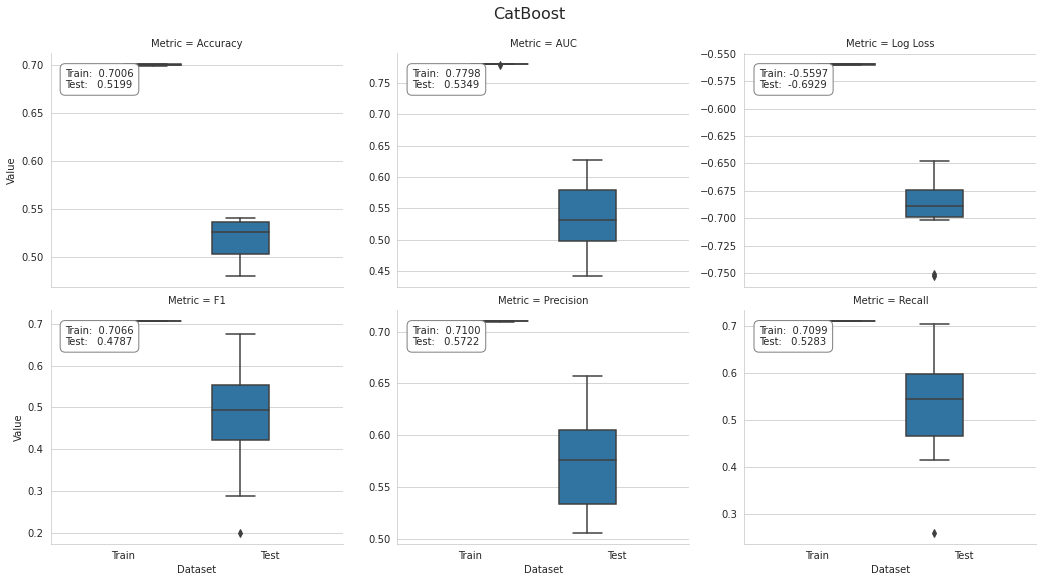

In [26]:
plot_result(cat_gpu_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

## Compare Results

In [95]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XGBoost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result,
           'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
Gradient Booster,0.536793,0.505439,0.454815,-0.696830,0.564898,0.555223
AdaBoost,0.536026,0.504680,0.462678,-0.692850,0.542952,0.571182
CatBoost,0.535570,0.530186,0.539839,-0.690083,0.579023,0.551868
CatBoost GPU,0.533815,0.521131,0.484439,-0.692181,0.574918,0.531375
LightGBM Factors,0.531961,0.507112,0.423222,-0.723949,0.555119,0.505033
LightGBM Dummies,0.531726,0.512568,0.432572,-0.704388,0.563982,0.503945
Random Forest,0.527617,0.517378,0.509683,-0.692599,0.567070,0.544931
XGBoost,0.523467,0.501340,0.392318,-0.705452,0.503652,0.496645
Baseline,0.503582,0.503582,0.516424,-17.070718,0.548116,0.505758


In [96]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 'sklearn_gbm', 
                      'xgboost', 'lgb_factors', 'lgb_dummies', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 'Gradient Booster', 
                      'XGBoost', 'LightGBM Dummies', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))

In [97]:
print(run_time)

{'dummy_clf': 3.888885736465454, 'random_forest': 534.8454701900482, 'adaboost': 394.19925689697266, 'sklearn_gbm': 54.56829643249512, 'xgboost': 385.2668263912201, 'lgb_factors': 57.30852460861206, 'lgb_dummies': 49.59844732284546, 'catboost': 1950.4419770240784, 'catboost_gpu': 642.1219692230225}


In [98]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv(results_path / 'runtime.csv')

In [99]:
# r = pd.read_csv(results_path / 'runtime.csv', index_col=0)

In [100]:
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
# auc = auc[auc.Model != 'Baseline']

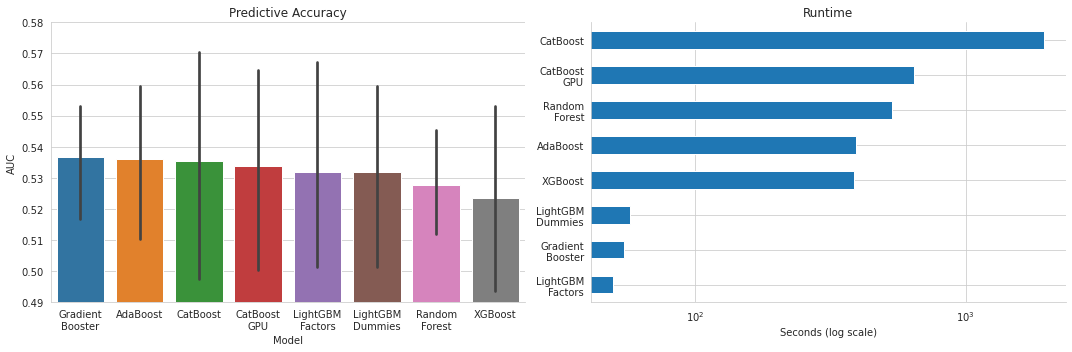

In [101]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
idx = df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index
sns.barplot(x='Model', y='AUC',
            data=auc,
            order=idx, ax=axes[0])
axes[0].set_xticklabels([c.replace(' ', '\n') for c in idx])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

(r.drop('Baseline').sort_values('t').rename(index=lambda x: x.replace(' ', '\n'))
 .plot.barh(title='Runtime', ax=axes[1], logx=True, legend=False))
axes[1].set_xlabel('Seconds (log scale)')
sns.despine()
fig.tight_layout()